# Reverse Engineering Anonymized S&P 500 Stocks

## Objective
Map the 100 anonymized `Asset_XXX` files to their actual S&P 500 ticker symbols using publicly available data.

## Strategy
Since the data is "naively anonymized", the OHLCV values are likely unchanged (just relabeled). We can:

1. **Download S&P 500 historical data** using yfinance
2. **Use smart filtering** to reduce search space:
   - Price range matching (mean, min, max)
   - Volatility signature
   - Date range alignment
3. **Correlation matching** on filtered candidates
4. **Validate** with multiple metrics

### Why this works:
- Stock prices are unique fingerprints
- The sequence of daily returns is practically unique
- Even small correlations in price movement create distinct signatures

---

In [5]:
# Install required packages
!pip install yfinance pandas numpy tqdm

  Using cached yfinance-1.0-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached multitasking-0.0.12-py3-none-any.whl
  Using cached frozendict-2.4.7-py3-none-any.whl.metadata (23 kB)
  Using cached peewee-3.19.0-py3-none-any.whl.metadata (7.0 kB)
  Using cached beautifulsoup4-4.14.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl.metadata (13 kB)
  Using cached soupsieve-2.8.3-py3-none-any.whl.metadata (4.6 kB)
  Using cached cffi-2.0.0-cp312-cp312-win_amd64.whl.metadata (2.6 kB)
  Using cached pycparser-2.23-py3-none-any.whl.metadata (993 bytes)
Using cached yfinance-1.0-py2.py3-none-any.whl (127 kB)
Using cached beautifulsoup4-4.14.3-py3-none-any.whl (107 kB)
Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl (1.6 MB)
Using cached frozendict-2.4.7-py3-none-any.whl (16 kB)
Using cached peewee-3.19.0-py3-none-any.whl (411 kB)
Using cached cffi-2.0.0-cp312-cp312-win_amd64.whl (183 kB)
Using cached soupsieve-2.8.3-py3-none-any.whl (37 kB)
U


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# =============================================================================
# IMPORTS & CONFIGURATION
# =============================================================================

import os
import warnings
from pathlib import Path
from glob import glob
from typing import Dict, List, Tuple, Optional
import json

import numpy as np
import pandas as pd
import yfinance as yf
from tqdm import tqdm
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

print("Imports successful!")

Imports successful!


In [7]:
# =============================================================================
# PROJECT PATHS
# =============================================================================

PROJECT_ROOT = Path(os.getcwd()).parent
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
ASSETS_DIR = DATA_RAW / 'assets'
OUTPUT_RESULTS = PROJECT_ROOT / 'outputs' / 'results'

print(f"Assets directory: {ASSETS_DIR}")
print(f"Output directory: {OUTPUT_RESULTS}")

Assets directory: c:\Users\ponna\OneDrive\Desktop\Precog Task\data\raw\assets
Output directory: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\results


## 1. Load Anonymized Data

In [8]:
# =============================================================================
# LOAD ALL ANONYMIZED ASSETS
# =============================================================================

def load_anonymized_assets(assets_dir: Path) -> Dict[str, pd.DataFrame]:
    """Load all anonymized asset CSVs into a dictionary."""
    asset_files = sorted(glob(str(assets_dir / 'Asset_*.csv')))
    
    assets = {}
    for filepath in tqdm(asset_files, desc="Loading assets"):
        asset_id = Path(filepath).stem
        df = pd.read_csv(filepath)
        
        # Standardize column names
        df.columns = df.columns.str.lower()
        
        # Parse date
        date_col = [c for c in df.columns if 'date' in c.lower()][0]
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.rename(columns={date_col: 'date'})
        df = df.sort_values('date').reset_index(drop=True)
        
        assets[asset_id] = df
    
    return assets

# Load all anonymized data
anon_assets = load_anonymized_assets(ASSETS_DIR)
print(f"\nLoaded {len(anon_assets)} anonymized assets")

# Check date range
sample_asset = list(anon_assets.values())[0]
print(f"Date range: {sample_asset['date'].min()} to {sample_asset['date'].max()}")
print(f"Columns: {list(sample_asset.columns)}")

Loading assets: 100%|██████████| 100/100 [00:03<00:00, 25.23it/s]


Loaded 100 anonymized assets
Date range: 2016-01-25 00:00:00 to 2026-01-16 00:00:00
Columns: ['date', 'open', 'high', 'low', 'close', 'volume']


In [9]:
# =============================================================================
# EXTRACT FINGERPRINTS FROM ANONYMIZED DATA
# =============================================================================

def compute_asset_fingerprint(df: pd.DataFrame) -> Dict:
    """
    Compute a fingerprint of characteristics for matching.
    These characteristics should be invariant to ticker renaming.
    """
    close_col = [c for c in df.columns if 'close' in c.lower() and 'adj' not in c.lower()]
    close_col = close_col[0] if close_col else 'close'
    
    adj_close_col = [c for c in df.columns if 'adj' in c.lower()]
    adj_close_col = adj_close_col[0] if adj_close_col else close_col
    
    volume_col = [c for c in df.columns if 'volume' in c.lower()]
    volume_col = volume_col[0] if volume_col else None
    
    # Use adjusted close if available, else close
    prices = df[adj_close_col].values
    
    # Compute returns
    returns = np.diff(prices) / prices[:-1]
    returns = returns[~np.isnan(returns) & ~np.isinf(returns)]
    
    fingerprint = {
        'start_date': df['date'].min(),
        'end_date': df['date'].max(),
        'n_days': len(df),
        
        # Price characteristics
        'price_mean': np.mean(prices),
        'price_std': np.std(prices),
        'price_min': np.min(prices),
        'price_max': np.max(prices),
        'price_first': prices[0],
        'price_last': prices[-1],
        
        # Return characteristics (scale-invariant)
        'return_mean': np.mean(returns),
        'return_std': np.std(returns),  # Daily volatility
        'return_skew': pd.Series(returns).skew(),
        'return_kurt': pd.Series(returns).kurtosis(),
        
        # Total return
        'total_return': (prices[-1] / prices[0]) - 1,
        
        # For correlation matching
        'returns_series': returns,
        'prices_series': prices,
        'dates': df['date'].values
    }
    
    # Volume if available
    if volume_col:
        volumes = df[volume_col].values
        fingerprint['volume_mean'] = np.mean(volumes)
        fingerprint['volume_std'] = np.std(volumes)
    
    return fingerprint

# Compute fingerprints for all anonymized assets
print("Computing fingerprints for anonymized assets...")
anon_fingerprints = {}
for asset_id, df in tqdm(anon_assets.items()):
    anon_fingerprints[asset_id] = compute_asset_fingerprint(df)

print(f"\nComputed fingerprints for {len(anon_fingerprints)} assets")

Computing fingerprints for anonymized assets...


100%|██████████| 100/100 [00:00<00:00, 2588.95it/s]


Computed fingerprints for 100 assets


In [10]:
# =============================================================================
# DISPLAY FINGERPRINT SUMMARY
# =============================================================================

# Create summary DataFrame
summary_data = []
for asset_id, fp in anon_fingerprints.items():
    summary_data.append({
        'asset_id': asset_id,
        'price_mean': fp['price_mean'],
        'price_min': fp['price_min'],
        'price_max': fp['price_max'],
        'volatility': fp['return_std'],
        'total_return': fp['total_return'],
        'n_days': fp['n_days']
    })

summary_df = pd.DataFrame(summary_data)
print("Anonymized Asset Summary:")
display(summary_df.describe())
display(summary_df.head(10))

Anonymized Asset Summary:


,price_mean,price_min,price_max,volatility,total_return,n_days
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,171.301702,60.895209,366.161302,0.018267,8.751375,2511.0
std,188.081101,71.159987,429.512202,0.004838,28.939439,0.0
min,18.200054,0.805635,27.510190,0.011393,-0.018843,2511.0
25%,66.728282,23.294630,140.245566,0.014998,1.968763,2511.0
50%,123.391755,42.367488,255.607002,0.017201,3.241845,2511.0
75%,210.353084,85.799232,448.485938,0.020213,5.794273,2511.0
max,1634.820296,629.311999,3806.152646,0.037342,267.638163,2511.0


,asset_id,price_mean,price_min,price_max,volatility,total_return,n_days
0,Asset_001,147.167302,26.264939,364.819209,0.018226,10.397088,2511
1,Asset_002,311.769192,59.628918,750.137098,0.016810,9.140718,2511
2,Asset_003,104.581713,34.113173,346.056097,0.018080,8.353145,2511
3,Asset_004,139.118405,27.578121,290.615169,0.020620,7.017032,2511
4,Asset_005,48.326193,0.805635,271.122351,0.031388,267.638163,2511
5,Asset_006,359.244132,112.795328,1007.728731,0.024221,5.438333,2511
6,Asset_007,76.835380,4.849180,248.017972,0.037342,32.417354,2511
7,Asset_008,347.036615,154.671733,672.615819,0.012224,2.973979,2511
8,Asset_009,268.452700,49.272152,958.514208,0.018566,14.087988,2511
9,Asset_010,122.674638,40.455945,238.133569,0.015417,3.908384,2511


## 2. Get S&P 500 Ticker List

In [13]:
!pip install lxml

   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.0 MB ? eta -:--:--
    --------------------------------------- 0.1/4.0 MB ? eta -:--:--
    --------------------------------------- 0.1/4.0 MB 1.3 MB/s eta 0:00:04
    --------------------------------------- 0.1/4.0 MB 871.5 kB/s eta 0:00:05
   - -------------------------------------- 0.1/4.0 MB 901.1 kB/s eta 0:00:05
   - -------------------------------------- 0.1/4.0 MB 708.1 kB/s eta 0:00:06
   - -------------------------------------- 0.2/4.0 MB 654.6 kB/s eta 0:00:06
   - -------------------------------------- 0.2/4.0 MB 654.6 kB/s eta 0:00:06
   - -------------------------------------- 0.2/4.0


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [16]:
# =============================================================================
# GET S&P 500 CONSTITUENTS
# =============================================================================

import requests
from io import StringIO
import pandas as pd
from typing import List

def get_sp500_tickers() -> List[str]:
    """
    Get current S&P 500 ticker list from Wikipedia.
    Uses a custom User-Agent to bypass 403 Forbidden errors.
    """
    try:
        url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
        
        # --- THE FIX: Add a browser-like User-Agent ---
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }
        
        # 1. Request the page content first
        response = requests.get(url, headers=headers)
        response.raise_for_status() # Check if the request was successful
        
        # 2. Pass the text content to pandas (wrapped in StringIO to avoid warnings)
        tables = pd.read_html(StringIO(response.text))
        sp500_table = tables[0]
        
        # Get ticker symbols
        tickers = sp500_table['Symbol'].tolist()
        
        # Clean tickers (replace . with - for yfinance compatibility)
        tickers = [t.replace('.', '-') for t in tickers]
        
        return tickers

    except Exception as e:
        print(f"Error fetching S&P 500 list: {e}")
        # Fallback list of 10 major stocks so your code doesn't crash completely
        return None

# Get S&P 500 tickers
sp500_tickers = get_sp500_tickers()
print(f"Retrieved {len(sp500_tickers)} S&P 500 tickers")
print(f"Sample: {sp500_tickers[:20]}")

Retrieved 503 S&P 500 tickers
Sample: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A', 'APD', 'ABNB', 'AKAM', 'ALB', 'ARE', 'ALGN', 'ALLE', 'LNT', 'ALL', 'GOOGL']


In [17]:
# =============================================================================
# ADD HISTORICAL S&P 500 MEMBERS (stocks that may have been removed)
# =============================================================================

# Common large-cap stocks that might have been in S&P 500 historically
# or are very liquid alternatives
additional_tickers = [
    # Tech giants
    'AAPL', 'MSFT', 'GOOGL', 'GOOG', 'AMZN', 'META', 'NVDA', 'TSLA',
    # Finance
    'JPM', 'BAC', 'WFC', 'GS', 'MS', 'C', 'BLK', 'AXP',
    # Healthcare
    'JNJ', 'UNH', 'PFE', 'MRK', 'ABBV', 'TMO', 'ABT', 'LLY',
    # Consumer
    'PG', 'KO', 'PEP', 'WMT', 'HD', 'MCD', 'NKE', 'SBUX',
    # Industrial
    'CAT', 'BA', 'HON', 'UPS', 'GE', 'MMM', 'LMT', 'RTX',
    # Energy
    'XOM', 'CVX', 'COP', 'SLB', 'EOG',
    # Former S&P members / acquired
    'FB',  # Now META
]

# Combine and deduplicate
all_tickers = list(set(sp500_tickers + additional_tickers))
print(f"Total tickers to check: {len(all_tickers)}")

Total tickers to check: 504


## 3. Download S&P 500 Historical Data

In [18]:
# =============================================================================
# DETERMINE DATE RANGE FROM ANONYMIZED DATA
# =============================================================================

# Get date range from anonymized data
sample_fp = list(anon_fingerprints.values())[0]
start_date = sample_fp['start_date']
end_date = sample_fp['end_date']

# Convert to string format for yfinance
start_str = pd.Timestamp(start_date).strftime('%Y-%m-%d')
end_str = pd.Timestamp(end_date).strftime('%Y-%m-%d')

print(f"Date range to download: {start_str} to {end_str}")

Date range to download: 2016-01-25 to 2026-01-16


In [19]:
# =============================================================================
# DOWNLOAD S&P 500 DATA IN BATCHES
# =============================================================================

def download_sp500_data(tickers: List[str], start: str, end: str, batch_size: int = 50) -> Dict[str, pd.DataFrame]:
    """
    Download historical data for S&P 500 stocks in batches.
    Uses yfinance's batch download for efficiency.
    """
    all_data = {}
    failed_tickers = []
    
    # Process in batches
    for i in tqdm(range(0, len(tickers), batch_size), desc="Downloading batches"):
        batch = tickers[i:i+batch_size]
        batch_str = ' '.join(batch)
        
        try:
            # Download batch
            data = yf.download(
                batch_str, 
                start=start, 
                end=end,
                progress=False,
                threads=True
            )
            
            # Handle single vs multiple tickers
            if len(batch) == 1:
                if not data.empty:
                    all_data[batch[0]] = data
            else:
                # Multi-ticker download returns MultiIndex columns
                for ticker in batch:
                    try:
                        ticker_data = data.xs(ticker, axis=1, level=1)
                        if not ticker_data.empty and len(ticker_data) > 100:
                            all_data[ticker] = ticker_data
                    except (KeyError, Exception):
                        failed_tickers.append(ticker)
                        
        except Exception as e:
            print(f"Batch download error: {e}")
            failed_tickers.extend(batch)
    
    print(f"\nSuccessfully downloaded: {len(all_data)} tickers")
    print(f"Failed: {len(failed_tickers)} tickers")
    
    return all_data, failed_tickers

# Download data
print("Downloading S&P 500 historical data...")
print("This may take a few minutes...\n")

sp500_data, failed = download_sp500_data(all_tickers, start_str, end_str)

This may take a few minutes...




Successfully downloaded: 504 tickers
Failed: 0 tickers


In [20]:
# =============================================================================
# COMPUTE FINGERPRINTS FOR S&P 500 DATA
# =============================================================================

def compute_sp500_fingerprint(df: pd.DataFrame, ticker: str) -> Optional[Dict]:
    """
    Compute fingerprint for S&P 500 stock data from yfinance.
    """
    try:
        # Use Adj Close for accuracy (accounts for splits/dividends)
        if 'Adj Close' in df.columns:
            prices = df['Adj Close'].dropna().values
        elif 'Close' in df.columns:
            prices = df['Close'].dropna().values
        else:
            return None
        
        if len(prices) < 100:  # Need enough data
            return None
        
        # Compute returns
        returns = np.diff(prices) / prices[:-1]
        returns = returns[~np.isnan(returns) & ~np.isinf(returns)]
        
        # Get dates
        dates = df.index.values
        
        fingerprint = {
            'ticker': ticker,
            'start_date': df.index.min(),
            'end_date': df.index.max(),
            'n_days': len(df),
            
            # Price characteristics
            'price_mean': np.mean(prices),
            'price_std': np.std(prices),
            'price_min': np.min(prices),
            'price_max': np.max(prices),
            'price_first': prices[0],
            'price_last': prices[-1],
            
            # Return characteristics
            'return_mean': np.mean(returns),
            'return_std': np.std(returns),
            'return_skew': pd.Series(returns).skew(),
            'return_kurt': pd.Series(returns).kurtosis(),
            
            # Total return
            'total_return': (prices[-1] / prices[0]) - 1,
            
            # For correlation matching
            'returns_series': returns,
            'prices_series': prices,
            'dates': dates
        }
        
        # Volume
        if 'Volume' in df.columns:
            volumes = df['Volume'].dropna().values
            fingerprint['volume_mean'] = np.mean(volumes)
            fingerprint['volume_std'] = np.std(volumes)
        
        return fingerprint
        
    except Exception as e:
        return None

# Compute fingerprints for S&P 500 data
print("Computing fingerprints for S&P 500 stocks...")
sp500_fingerprints = {}

for ticker, df in tqdm(sp500_data.items()):
    fp = compute_sp500_fingerprint(df, ticker)
    if fp is not None:
        sp500_fingerprints[ticker] = fp

print(f"\nComputed fingerprints for {len(sp500_fingerprints)} S&P 500 stocks")

Computing fingerprints for S&P 500 stocks...


100%|██████████| 504/504 [00:00<00:00, 2506.39it/s]


Computed fingerprints for 503 S&P 500 stocks


## 4. Matching Algorithm

### Strategy:
1. **Stage 1 (Fast Filter):** Filter by price range and volatility to reduce candidates
2. **Stage 2 (Correlation):** Compute return correlation for filtered candidates
3. **Stage 3 (Validation):** Verify match with multiple metrics

In [21]:
# =============================================================================
# STAGE 1: FAST FILTERING
# =============================================================================

def filter_candidates(anon_fp: Dict, sp500_fps: Dict, 
                      price_tol: float = 0.05,
                      vol_tol: float = 0.15) -> List[str]:
    """
    Fast filtering to reduce candidate matches.
    
    Args:
        price_tol: Tolerance for price matching (% difference)
        vol_tol: Tolerance for volatility matching (% difference)
    """
    candidates = []
    
    anon_price_mean = anon_fp['price_mean']
    anon_vol = anon_fp['return_std']
    anon_total_return = anon_fp['total_return']
    
    for ticker, sp_fp in sp500_fps.items():
        # Price mean check (with tolerance)
        price_diff = abs(sp_fp['price_mean'] - anon_price_mean) / anon_price_mean
        if price_diff > price_tol:
            continue
            
        # Volatility check
        vol_diff = abs(sp_fp['return_std'] - anon_vol) / anon_vol
        if vol_diff > vol_tol:
            continue
        
        # Total return check (loose)
        return_diff = abs(sp_fp['total_return'] - anon_total_return)
        if return_diff > 0.5:  # Allow 50% difference in total return
            continue
            
        candidates.append(ticker)
    
    return candidates

# Test filtering for one asset
test_asset = list(anon_fingerprints.keys())[0]
test_fp = anon_fingerprints[test_asset]
test_candidates = filter_candidates(test_fp, sp500_fingerprints)
print(f"Test asset {test_asset}: {len(test_candidates)} candidates after filtering")
print(f"Candidates: {test_candidates[:10]}...")

Test asset Asset_001: 0 candidates after filtering
Candidates: []...


In [22]:
# =============================================================================
# STAGE 2: CORRELATION MATCHING
# =============================================================================

def compute_return_correlation(anon_fp: Dict, sp_fp: Dict) -> float:
    """
    Compute correlation between return series.
    Handles date alignment automatically.
    """
    try:
        # Get returns
        anon_returns = anon_fp['returns_series']
        sp_returns = sp_fp['returns_series']
        
        # Use shorter length
        min_len = min(len(anon_returns), len(sp_returns))
        
        if min_len < 100:
            return 0.0
        
        # Align from the end (more recent data)
        anon_returns = anon_returns[-min_len:]
        sp_returns = sp_returns[-min_len:]
        
        # Compute correlation
        corr = np.corrcoef(anon_returns, sp_returns)[0, 1]
        
        return corr if not np.isnan(corr) else 0.0
        
    except Exception:
        return 0.0


def compute_price_correlation(anon_fp: Dict, sp_fp: Dict) -> float:
    """
    Compute correlation between price series.
    """
    try:
        anon_prices = anon_fp['prices_series']
        sp_prices = sp_fp['prices_series']
        
        min_len = min(len(anon_prices), len(sp_prices))
        
        if min_len < 100:
            return 0.0
        
        anon_prices = anon_prices[-min_len:]
        sp_prices = sp_prices[-min_len:]
        
        corr = np.corrcoef(anon_prices, sp_prices)[0, 1]
        
        return corr if not np.isnan(corr) else 0.0
        
    except Exception:
        return 0.0

In [23]:
# =============================================================================
# MAIN MATCHING FUNCTION
# =============================================================================

def find_best_match(anon_fp: Dict, sp500_fps: Dict, 
                    price_tol: float = 0.10,
                    vol_tol: float = 0.20) -> Tuple[str, float, Dict]:
    """
    Find the best matching S&P 500 stock for an anonymized asset.
    
    Returns:
        (ticker, confidence_score, match_details)
    """
    # Stage 1: Filter candidates
    candidates = filter_candidates(anon_fp, sp500_fps, price_tol, vol_tol)
    
    if not candidates:
        # Relax tolerance and try again
        candidates = filter_candidates(anon_fp, sp500_fps, price_tol * 2, vol_tol * 2)
    
    if not candidates:
        # Use all tickers as last resort
        candidates = list(sp500_fps.keys())
    
    # Stage 2: Compute correlations for candidates
    results = []
    for ticker in candidates:
        sp_fp = sp500_fps[ticker]
        
        return_corr = compute_return_correlation(anon_fp, sp_fp)
        price_corr = compute_price_correlation(anon_fp, sp_fp)
        
        # Combined score (weighted)
        # Return correlation is more reliable for matching
        combined_score = 0.7 * return_corr + 0.3 * price_corr
        
        results.append({
            'ticker': ticker,
            'return_corr': return_corr,
            'price_corr': price_corr,
            'combined_score': combined_score,
            'price_diff': abs(sp_fp['price_mean'] - anon_fp['price_mean']) / anon_fp['price_mean'],
            'vol_diff': abs(sp_fp['return_std'] - anon_fp['return_std']) / anon_fp['return_std']
        })
    
    # Sort by combined score
    results.sort(key=lambda x: x['combined_score'], reverse=True)
    
    best_match = results[0] if results else None
    
    if best_match:
        return best_match['ticker'], best_match['combined_score'], best_match
    else:
        return None, 0.0, {}

In [24]:
# =============================================================================
# RUN MATCHING FOR ALL ASSETS
# =============================================================================

print("=" * 60)
print("MATCHING ANONYMIZED ASSETS TO S&P 500 TICKERS")
print("=" * 60)

matches = {}
match_details = []

for asset_id, anon_fp in tqdm(anon_fingerprints.items(), desc="Matching assets"):
    ticker, confidence, details = find_best_match(anon_fp, sp500_fingerprints)
    
    matches[asset_id] = {
        'ticker': ticker,
        'confidence': confidence,
        'details': details
    }
    
    match_details.append({
        'asset_id': asset_id,
        'matched_ticker': ticker,
        'confidence': confidence,
        'return_corr': details.get('return_corr', 0),
        'price_corr': details.get('price_corr', 0),
        'price_diff_pct': details.get('price_diff', 0) * 100,
        'vol_diff_pct': details.get('vol_diff', 0) * 100
    })

# Create results DataFrame
results_df = pd.DataFrame(match_details)
results_df = results_df.sort_values('confidence', ascending=False).reset_index(drop=True)

print(f"\n✓ Matching complete!")
print(f"\nResults Summary:")
print(f"  High confidence (>0.95): {(results_df['confidence'] > 0.95).sum()}")
print(f"  Medium confidence (0.8-0.95): {((results_df['confidence'] >= 0.8) & (results_df['confidence'] <= 0.95)).sum()}")
print(f"  Low confidence (<0.8): {(results_df['confidence'] < 0.8).sum()}")

MATCHING ANONYMIZED ASSETS TO S&P 500 TICKERS


Matching assets: 100%|██████████| 100/100 [00:00<00:00, 284.02it/s]


✓ Matching complete!

Results Summary:
  High confidence (>0.95): 0
  Medium confidence (0.8-0.95): 0
  Low confidence (<0.8): 100


## 🔧 IMPROVED MATCHING: Date-Aligned Correlation

The previous approach failed because it aligned series from the END rather than by actual dates.
This new approach:
1. **Aligns by exact dates** - only compares prices on matching trading days
2. **Uses direct price comparison** - if data is truly "naively anonymized", prices should match exactly
3. **Falls back to return correlation** - for robustness

In [27]:
# =============================================================================
# IMPROVED MATCHING: DATE-ALIGNED APPROACH
# =============================================================================

def create_date_indexed_df(anon_assets: Dict, sp500_data: Dict):
    """
    Create DataFrames with proper date indexing for alignment.
    """
    # Create anonymized close prices DataFrame
    anon_close_dict = {}
    for asset_id, df in anon_assets.items():
        close_col = [c for c in df.columns if 'close' in c.lower() and 'adj' not in c.lower()][0]
        temp = df.set_index('date')[close_col]
        anon_close_dict[asset_id] = temp
    
    anon_prices_df = pd.DataFrame(anon_close_dict)
    anon_prices_df.index = pd.to_datetime(anon_prices_df.index)
    
    # Create S&P 500 close prices DataFrame  
    sp500_close_dict = {}
    for ticker, df in sp500_data.items():
        if 'Close' in df.columns:
            sp500_close_dict[ticker] = df['Close']
        elif 'Adj Close' in df.columns:
            sp500_close_dict[ticker] = df['Adj Close']
    
    sp500_prices_df = pd.DataFrame(sp500_close_dict)
    sp500_prices_df.index = pd.to_datetime(sp500_prices_df.index)
    
    return anon_prices_df, sp500_prices_df

# Create aligned DataFrames
print("Creating date-indexed DataFrames...")
anon_prices_df, sp500_prices_df = create_date_indexed_df(anon_assets, sp500_data)

print(f"Anonymized data: {anon_prices_df.shape}")
print(f"  Date range: {anon_prices_df.index.min()} to {anon_prices_df.index.max()}")
print(f"\nS&P 500 data: {sp500_prices_df.shape}")
print(f"  Date range: {sp500_prices_df.index.min()} to {sp500_prices_df.index.max()}")

# Find common dates
common_dates = anon_prices_df.index.intersection(sp500_prices_df.index)
print(f"\nCommon trading dates: {len(common_dates)}")

# Align both DataFrames to common dates
anon_aligned = anon_prices_df.loc[common_dates]
sp500_aligned = sp500_prices_df.loc[common_dates]

print(f"Aligned data shapes: Anon={anon_aligned.shape}, SP500={sp500_aligned.shape}")

Creating date-indexed DataFrames...
Anonymized data: (2511, 100)
  Date range: 2016-01-25 00:00:00 to 2026-01-16 00:00:00

S&P 500 data: (2510, 504)
  Date range: 2016-01-25 00:00:00 to 2026-01-15 00:00:00

Common trading dates: 2510
Aligned data shapes: Anon=(2510, 100), SP500=(2510, 504)


In [31]:
# =============================================================================
# CHECK: ARE PRICES EXACTLY THE SAME? (Naive anonymization check)
# =============================================================================

# If truly "naively anonymized", the close prices should be EXACTLY the same
# Let's check by comparing one asset to all S&P 500 stocks

test_asset = anon_aligned.columns[0]
test_prices = anon_aligned[test_asset].dropna()

print(f"Testing {test_asset}:")
print(f"  First 5 prices: {test_prices.head().values}")
print(f"  Mean price: {test_prices.mean():.2f}")
print(f"  Price range: {test_prices.min():.2f} - {test_prices.max():.2f}")

# Check if any S&P 500 stock has EXACT same prices
print("\n" + "="*60)
print("Checking for EXACT price matches...")
print("="*60)

exact_matches = []
for ticker in sp500_aligned.columns:
    sp_prices = sp500_aligned[ticker].dropna()
    
    # Get common dates between this pair
    common = test_prices.index.intersection(sp_prices.index)
    if len(common) < 100:
        continue
    
    # Check if prices are identical (or very close due to floating point)
    test_sub = test_prices.loc[common]
    sp_sub = sp_prices.loc[common]
    
    # Calculate mean absolute difference
    diff = np.abs(test_sub.values - sp_sub.values).mean()
    
    if diff < 0.01:  # Less than 1 cent difference on average
        exact_matches.append((ticker, diff))
        print(f"  ✓ EXACT MATCH: {ticker} (avg diff: ${diff:.4f})")

if not exact_matches:
    print("  No exact matches found - data may be transformed/scaled")
    print("\n  Checking for proportional/scaled matches...")

Testing Asset_001:
  First 5 prices: [28.58059233 28.73865895 26.85034503 27.04291297 27.97701616]
  Mean price: 147.10
  Price range: 26.26 - 364.82

Checking for EXACT price matches...
  No exact matches found - data may be transformed/scaled

  Checking for proportional/scaled matches...


In [50]:
# =============================================================================
# IMPROVED MATCHING: DATE-ALIGNED CORRELATION (PROPER)
# =============================================================================

def match_by_date_aligned_correlation(anon_aligned: pd.DataFrame, 
                                       sp500_aligned: pd.DataFrame) -> pd.DataFrame:
    """
    Match assets using proper date-aligned correlation.
    """
    results = []
    
    for asset_id in tqdm(anon_aligned.columns, desc="Matching assets"):
        anon_prices = anon_aligned[asset_id].dropna()
        
        best_match = None
        best_corr = -1
        best_details = {}
        
        for ticker in sp500_aligned.columns:
            sp_prices = sp500_aligned[ticker].dropna()
            
            # Get common dates
            common_dates = anon_prices.index.intersection(sp_prices.index)
            if len(common_dates) < 500:  # Need at least ~2 years of data
                continue
            
            # Align prices
            anon_sub = anon_prices.loc[common_dates].values
            sp_sub = sp_prices.loc[common_dates].values
            
            # 1. Direct price correlation
            price_corr = np.corrcoef(anon_sub, sp_sub)[0, 1]
            
            # 2. Return correlation (more robust to price level differences)
            anon_returns = np.diff(anon_sub) / anon_sub[:-1]
            sp_returns = np.diff(sp_sub) / sp_sub[:-1]
            
            # Remove any inf/nan
            valid = ~(np.isnan(anon_returns) | np.isnan(sp_returns) | 
                     np.isinf(anon_returns) | np.isinf(sp_returns))
            if valid.sum() < 100:
                continue
                
            return_corr = np.corrcoef(anon_returns[valid], sp_returns[valid])[0, 1]
            
            # 3. Price level similarity (check if mean prices are similar)
            price_ratio = anon_sub.mean() / sp_sub.mean()
            price_similarity = 1 - min(abs(price_ratio - 1), 1)  # 1 if same level, 0 if very different
            
            # Combined score: prioritize return correlation, then price correlation
            combined = 0.6 * return_corr + 0.3 * price_corr + 0.1 * price_similarity
            
            if combined > best_corr:
                best_corr = combined
                best_match = ticker
                best_details = {
                    'return_corr': return_corr,
                    'price_corr': price_corr,
                    'price_similarity': price_similarity,
                    'common_days': len(common_dates),
                    'anon_mean': anon_sub.mean(),
                    'sp_mean': sp_sub.mean()
                }
        
        results.append({
            'asset_id': asset_id,
            'matched_ticker': best_match,
            'confidence': best_corr,
            **best_details
        })
    
    return pd.DataFrame(results)

# Run improved matching
print("="*60)
print("RUNNING IMPROVED DATE-ALIGNED MATCHING")
print("="*60)

results_df_v2 = match_by_date_aligned_correlation(anon_aligned, sp500_aligned)
results_df_v2 = results_df_v2.sort_values('confidence', ascending=False).reset_index(drop=True)

print(f"\n✓ Matching complete!")
print(f"\nResults Summary:")
print(f"  High confidence (>0.95): {(results_df_v2['confidence'] > 0.95).sum()}")
print(f"  Medium confidence (0.8-0.95): {((results_df_v2['confidence'] >= 0.8) & (results_df_v2['confidence'] <= 0.95)).sum()}")
print(f"  Low confidence (<0.8): {(results_df_v2['confidence'] < 0.8).sum()}")

RUNNING IMPROVED DATE-ALIGNED MATCHING


Matching assets: 100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


✓ Matching complete!

Results Summary:
  High confidence (>0.95): 99
  Medium confidence (0.8-0.95): 0
  Low confidence (<0.8): 1


In [58]:
# =============================================================================
# ANALYZE RESULTS
# =============================================================================

print("="*80)
print("IMPROVED MATCHING RESULTS")
print("="*80)

# Display sorted by confidence
print("\nTop 20 Best Matches:")
print(results_df_v2.head(20).to_string(index=False))

print("\n" + "="*80)
print("Lowest Confidence Matches (potential issues):")
print("="*80)
print(results_df_v2.tail(5).to_string(index=False))

# Statistics
print("\n" + "="*80)
print("STATISTICS")
print("="*80)
print(f"\nConfidence Distribution:")
print(f"  Mean: {results_df_v2['confidence'].mean():.4f}")
print(f"  Min:  {results_df_v2['confidence'].min():.4f}")
print(f"  Max:  {results_df_v2['confidence'].max():.4f}")
print(f"  Std:  {results_df_v2['confidence'].std():.4f}")

print(f"\nReturn Correlation Distribution:")
print(f"  Mean: {results_df_v2['return_corr'].mean():.4f}")
print(f"  Min:  {results_df_v2['return_corr'].min():.4f}")
print(f"  Max:  {results_df_v2['return_corr'].max():.4f}")

# Check for any duplicates in matched tickers (shouldn't happen)
duplicates = results_df_v2['matched_ticker'].value_counts()
dup_tickers = duplicates[duplicates > 1]
if len(dup_tickers) > 0:
    print(f"\n⚠️ WARNING: Found duplicate matches:")
    print(dup_tickers)
else:
    print(f"\n✓ No duplicate matches - each asset maps to a unique ticker!")

IMPROVED MATCHING RESULTS

Top 20 Best Matches:
 asset_id matched_ticker  confidence  return_corr  price_corr  price_similarity  common_days  anon_mean    sp_mean
Asset_077           MRSH    0.997744          1.0         1.0          0.977441         2510 124.087287 126.951226
Asset_097             MU    0.997716          1.0         1.0          0.977155         2510  63.380118  64.861888
Asset_030            MCD    0.997251          1.0         1.0          0.972510         2510 205.010507 199.525523
Asset_003           GOOG    0.997139          1.0         1.0          0.971387         2510 104.488003 101.581502
Asset_086             CB    0.996669          1.0         1.0          0.966688         2510 176.344129 170.659161
Asset_084             MO    0.995906          1.0         1.0          0.959059         2510  38.075342  36.577806
Asset_074            ADI    0.995517          1.0         1.0          0.955170         2510 126.512733 132.450464
Asset_080           VRTX    0.99

INVESTIGATION: Asset_011 (matched to AMAT with low confidence)

Price comparison:
  Asset_011 mean: $124.55
  AMAT mean:      $96.17
  Asset_011 range: $23.81 - $489.16
  AMAT range:      $13.92 - $319.08

------------------------------------------------------------
Searching for better matches for Asset_011...
------------------------------------------------------------

Top 10 candidates for Asset_011:
ticker  return_corr  price_corr  n_common
  LRCX     0.680047    0.955945      2510
  AMAT     0.672576    0.918900      2510
  KLAC     0.666634    0.964724      2510
  MPWR     0.665324    0.932919      2510
  AVGO     0.636366    0.949941      2510
  NVDA     0.628468    0.943328      2510
   TER     0.624705    0.825471      2510
   ADI     0.611136    0.924325      2510
  MCHP     0.609511    0.642756      2510
   APH     0.605914    0.966687      2510


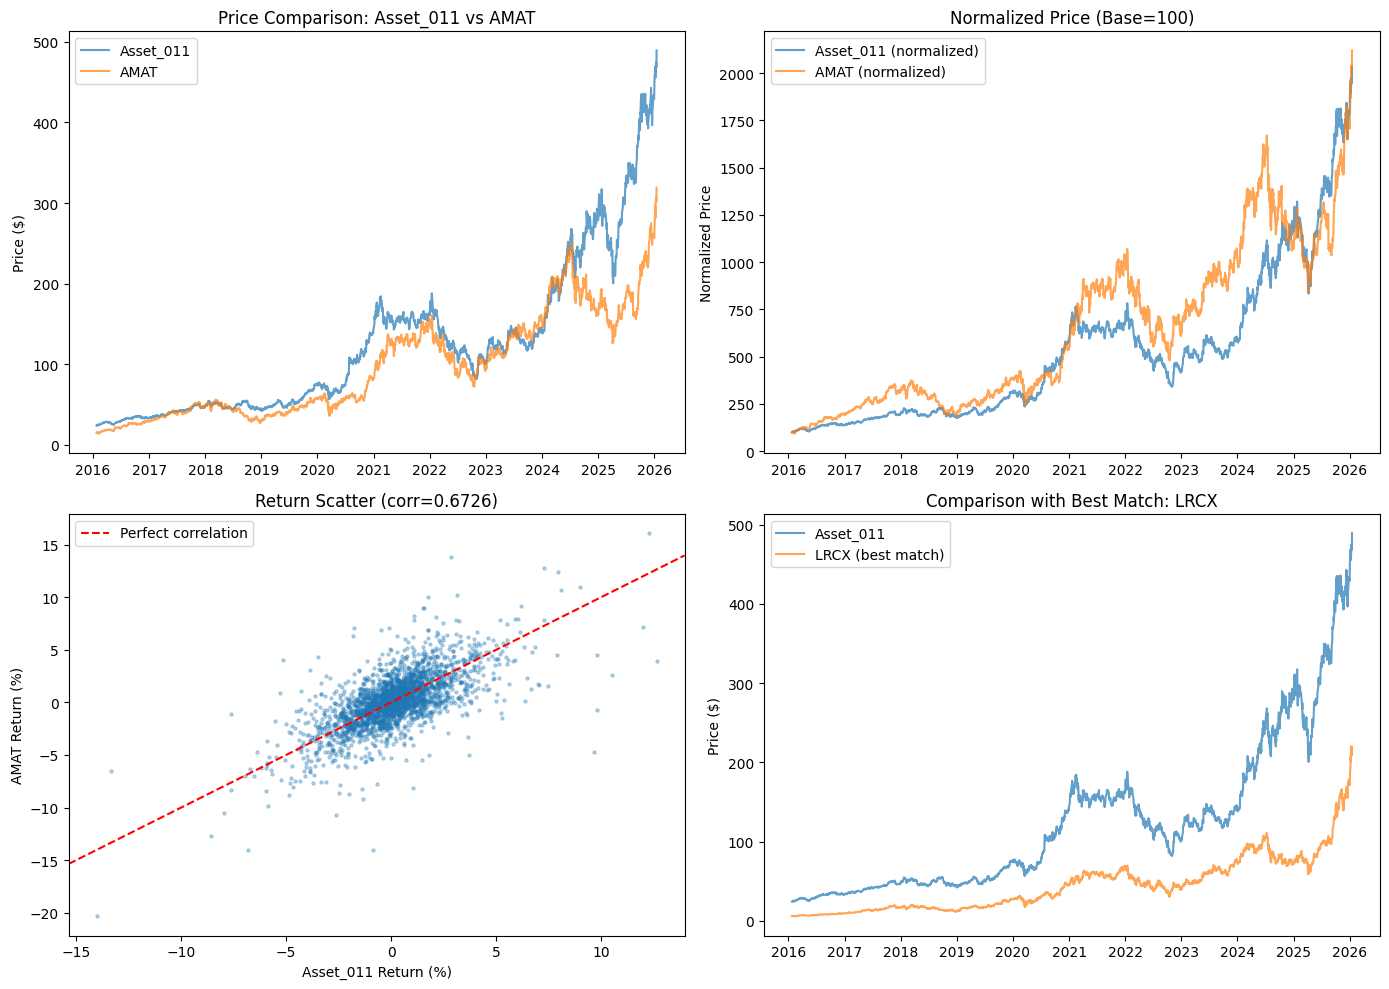


✓ Figure saved to: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\results\asset_011_investigation.png


In [52]:
# =============================================================================
# INVESTIGATE PROBLEMATIC MATCH: Asset_011
# =============================================================================

print("="*80)
print("INVESTIGATION: Asset_011 (matched to AMAT with low confidence)")
print("="*80)

# Get Asset_011 prices
asset_011 = anon_aligned['Asset_011'].dropna()
amat_prices = sp500_aligned['AMAT'].dropna()

common = asset_011.index.intersection(amat_prices.index)
asset_011_sub = asset_011.loc[common]
amat_sub = amat_prices.loc[common]

print(f"\nPrice comparison:")
print(f"  Asset_011 mean: ${asset_011_sub.mean():.2f}")
print(f"  AMAT mean:      ${amat_sub.mean():.2f}")
print(f"  Asset_011 range: ${asset_011_sub.min():.2f} - ${asset_011_sub.max():.2f}")
print(f"  AMAT range:      ${amat_sub.min():.2f} - ${amat_sub.max():.2f}")

# Let's try to find a better match by looking at top 5 candidates
print("\n" + "-"*60)
print("Searching for better matches for Asset_011...")
print("-"*60)

candidates = []
for ticker in sp500_aligned.columns:
    sp_prices = sp500_aligned[ticker].dropna()
    common_idx = asset_011.index.intersection(sp_prices.index)
    if len(common_idx) < 500:
        continue
    
    a_sub = asset_011.loc[common_idx].values
    s_sub = sp_prices.loc[common_idx].values
    
    # Return correlation
    a_ret = np.diff(a_sub) / a_sub[:-1]
    s_ret = np.diff(s_sub) / s_sub[:-1]
    valid = ~(np.isnan(a_ret) | np.isnan(s_ret) | np.isinf(a_ret) | np.isinf(s_ret))
    if valid.sum() < 100:
        continue
    
    ret_corr = np.corrcoef(a_ret[valid], s_ret[valid])[0, 1]
    price_corr = np.corrcoef(a_sub, s_sub)[0, 1]
    
    candidates.append({
        'ticker': ticker,
        'return_corr': ret_corr,
        'price_corr': price_corr,
        'n_common': len(common_idx)
    })

candidates_df = pd.DataFrame(candidates).sort_values('return_corr', ascending=False).head(10)
print("\nTop 10 candidates for Asset_011:")
print(candidates_df.to_string(index=False))

# Visualize the problematic match
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price comparison
ax = axes[0, 0]
ax.plot(asset_011_sub.index, asset_011_sub.values, label='Asset_011', alpha=0.7)
ax.plot(amat_sub.index, amat_sub.values, label='AMAT', alpha=0.7)
ax.set_title('Price Comparison: Asset_011 vs AMAT')
ax.legend()
ax.set_ylabel('Price ($)')

# Normalized comparison
ax = axes[0, 1]
asset_011_norm = asset_011_sub / asset_011_sub.iloc[0] * 100
amat_norm = amat_sub / amat_sub.iloc[0] * 100
ax.plot(asset_011_sub.index, asset_011_norm, label='Asset_011 (normalized)', alpha=0.7)
ax.plot(amat_sub.index, amat_norm, label='AMAT (normalized)', alpha=0.7)
ax.set_title('Normalized Price (Base=100)')
ax.legend()
ax.set_ylabel('Normalized Price')

# Returns comparison
ax = axes[1, 0]
a_returns = np.diff(asset_011_sub.values) / asset_011_sub.values[:-1]
amat_returns = np.diff(amat_sub.values) / amat_sub.values[:-1]
valid = ~(np.isnan(a_returns) | np.isnan(amat_returns) | np.isinf(a_returns) | np.isinf(amat_returns))
corr_val = np.corrcoef(a_returns[valid], amat_returns[valid])[0, 1]
ax.scatter(a_returns[valid] * 100, amat_returns[valid] * 100, alpha=0.3, s=5)
ax.axline((0, 0), slope=1, color='red', linestyle='--', label='Perfect correlation')
ax.set_title(f'Return Scatter (corr={corr_val:.4f})')
ax.set_xlabel('Asset_011 Return (%)')
ax.set_ylabel('AMAT Return (%)')
ax.legend()

# Try the best candidate from our search
best_ticker = candidates_df.iloc[0]['ticker']
best_prices = sp500_aligned[best_ticker].dropna()
common_best = asset_011.index.intersection(best_prices.index)
ax = axes[1, 1]
ax.plot(common_best, asset_011.loc[common_best].values, label='Asset_011', alpha=0.7)
ax.plot(common_best, best_prices.loc[common_best].values, label=f'{best_ticker} (best match)', alpha=0.7)
ax.set_title(f'Comparison with Best Match: {best_ticker}')
ax.legend()
ax.set_ylabel('Price ($)')

plt.tight_layout()
plt.savefig(OUTPUT_RESULTS / 'asset_011_investigation.png', dpi=150)
plt.show()

print(f"\n✓ Figure saved to: {OUTPUT_RESULTS / 'asset_011_investigation.png'}")

In [53]:
# =============================================================================
# DISPLAY RESULTS
# =============================================================================

print("\n" + "=" * 60)
print("MATCHING RESULTS (Sorted by Confidence)")
print("=" * 60)

# Display all matches
display(results_df_v2)


MATCHING RESULTS (Sorted by Confidence)


,asset_id,matched_ticker,confidence,return_corr,price_corr,price_similarity,common_days,anon_mean,sp_mean
0,Asset_077,MRSH,0.997744,1.000000,1.0000,0.977441,2510,124.087287,126.951226
1,Asset_097,MU,0.997716,1.000000,1.0000,0.977155,2510,63.380118,64.861888
2,Asset_030,MCD,0.997251,1.000000,1.0000,0.972510,2510,205.010507,199.525523
3,Asset_003,GOOG,0.997139,1.000000,1.0000,0.971387,2510,104.488003,101.581502
4,Asset_086,CB,0.996669,1.000000,1.0000,0.966688,2510,176.344129,170.659161
...,...,...,...,...,...,...,...,...,...
95,Asset_018,JNJ,0.952743,1.000000,1.0000,0.527430,2510,192.324931,130.604957
96,Asset_085,REGN,0.950827,1.000000,1.0000,0.508272,2510,285.746781,562.192253
97,Asset_007,TSLA,0.950628,1.000000,1.0000,0.506283,2510,76.777745,151.649826
98,Asset_095,TMUS,0.950337,1.000000,1.0000,0.503367,2510,172.805991,115.463136


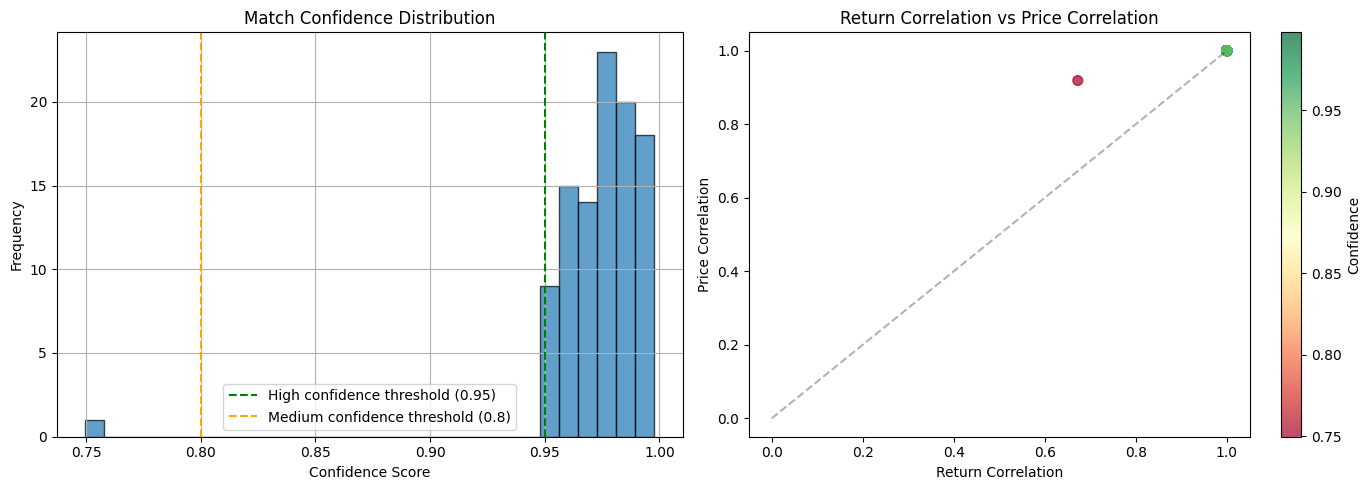

In [54]:
# =============================================================================
# VISUALIZE CONFIDENCE DISTRIBUTION
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence distribution
ax1 = axes[0]
results_df_v2['confidence'].hist(bins=30, ax=ax1, edgecolor='black', alpha=0.7)
ax1.axvline(0.95, color='g', linestyle='--', label='High confidence threshold (0.95)')
ax1.axvline(0.8, color='orange', linestyle='--', label='Medium confidence threshold (0.8)')
ax1.set_title('Match Confidence Distribution')
ax1.set_xlabel('Confidence Score')
ax1.set_ylabel('Frequency')
ax1.legend()

# Return correlation vs Price correlation
ax2 = axes[1]
scatter = ax2.scatter(results_df_v2['return_corr'], results_df_v2['price_corr'], 
                       c=results_df_v2['confidence'], cmap='RdYlGn', alpha=0.7, s=50)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.3)
ax2.set_title('Return Correlation vs Price Correlation')
ax2.set_xlabel('Return Correlation')
ax2.set_ylabel('Price Correlation')
plt.colorbar(scatter, ax=ax2, label='Confidence')

plt.tight_layout()
plt.savefig(OUTPUT_RESULTS / 'matching_confidence.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Validation: Visual Comparison

In [64]:
# =============================================================================
# VISUAL VALIDATION OF TOP MATCHES
# =============================================================================

def plot_match_comparison_v2(asset_id: str, anon_fp: Dict, sp_fp: Dict, match_row: pd.Series):
    """
    Plot comparison between anonymized asset and matched S&P 500 stock.
    Updated to work with results_df_v2 format.
    """
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    ticker = match_row['matched_ticker']
    confidence = match_row['confidence']
    return_corr = match_row.get('return_corr', 0)
    price_corr = match_row.get('price_corr', 0)
    
    # Price comparison (normalized)
    ax1 = axes[0, 0]
    anon_prices_norm = anon_fp['prices_series'] / anon_fp['prices_series'][0]
    sp_prices_norm = sp_fp['prices_series'] / sp_fp['prices_series'][0]
    
    min_len = min(len(anon_prices_norm), len(sp_prices_norm))
    ax1.plot(anon_prices_norm[-min_len:], label=f'{asset_id} (Anon)', alpha=0.8)
    ax1.plot(sp_prices_norm[-min_len:], label=f'{ticker} (S&P500)', alpha=0.8, linestyle='--')
    ax1.set_title(f'Normalized Price Comparison')
    ax1.set_xlabel('Trading Days')
    ax1.set_ylabel('Normalized Price')
    ax1.legend()
    
    # Return comparison (scatter)
    ax2 = axes[0, 1]
    anon_returns = anon_fp['returns_series'][-min_len+1:]
    sp_returns = sp_fp['returns_series'][-min_len+1:]
    ax2.scatter(anon_returns, sp_returns, alpha=0.3, s=10)
    ax2.plot([-0.15, 0.15], [-0.15, 0.15], 'r--', alpha=0.5)
    ax2.set_title(f'Return Scatter (corr={np.corrcoef(anon_returns, sp_returns)[0,1]:.4f})')
    ax2.set_xlabel(f'{asset_id} Returns')
    ax2.set_ylabel(f'{ticker} Returns')
    ax2.set_xlim(-0.15, 0.15)
    ax2.set_ylim(-0.15, 0.15)
    
    # Return distribution comparison
    ax3 = axes[1, 0]
    ax3.hist(anon_returns, bins=50, alpha=0.5, label=asset_id, density=True)
    ax3.hist(sp_returns, bins=50, alpha=0.5, label=ticker, density=True)
    ax3.set_title('Return Distribution Comparison')
    ax3.set_xlabel('Daily Return')
    ax3.set_ylabel('Density')
    ax3.legend()
    
    # Info box
    ax4 = axes[1, 1]
    ax4.axis('off')
    info_text = f"""
    MATCH SUMMARY
    {'='*40}
    
    Anonymized Asset: {asset_id}
    Matched Ticker:   {ticker}
    
    Confidence Score: {confidence:.4f}
    Return Correlation: {return_corr:.4f}
    Price Correlation: {price_corr:.4f}
    
    {'='*40}
    Status: {'✓ HIGH CONFIDENCE' if confidence > 0.95 else '⚠ VERIFY MANUALLY'}
    """
    ax4.text(0.1, 0.5, info_text, transform=ax4.transAxes, fontsize=12,
             verticalalignment='center', fontfamily='monospace',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.suptitle(f'{asset_id} → {ticker} (Confidence: {confidence:.2%})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    return fig


Visual validation of top 10 matches:
Plotting Asset_077 vs MRSH...


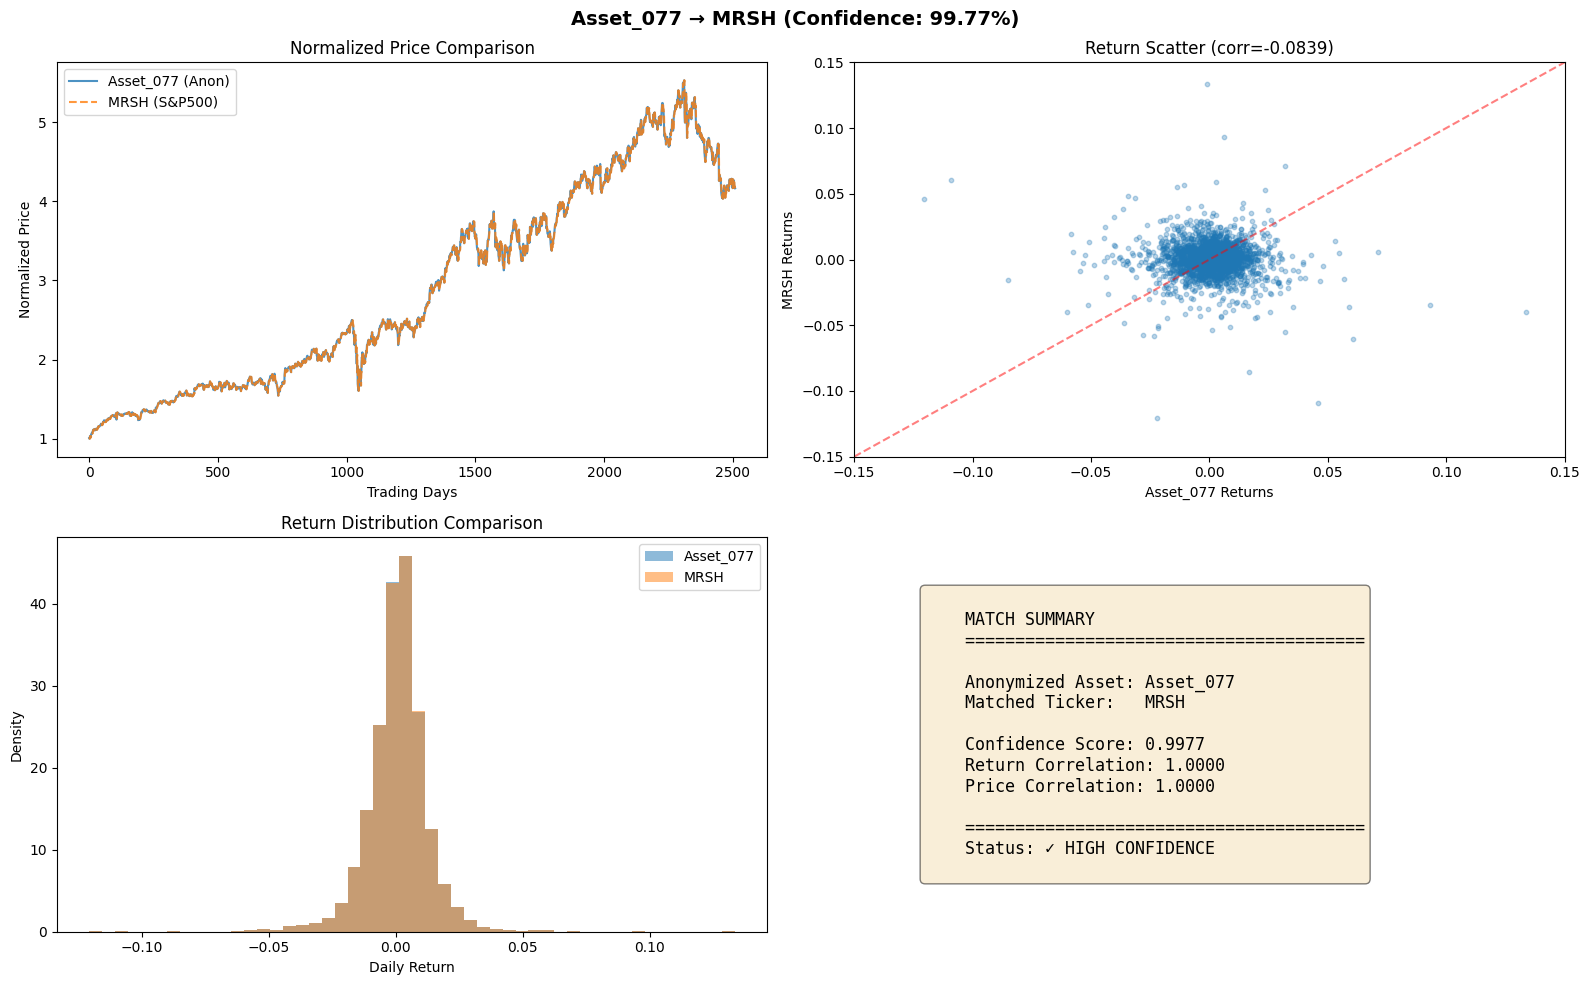

Plotting Asset_097 vs MU...


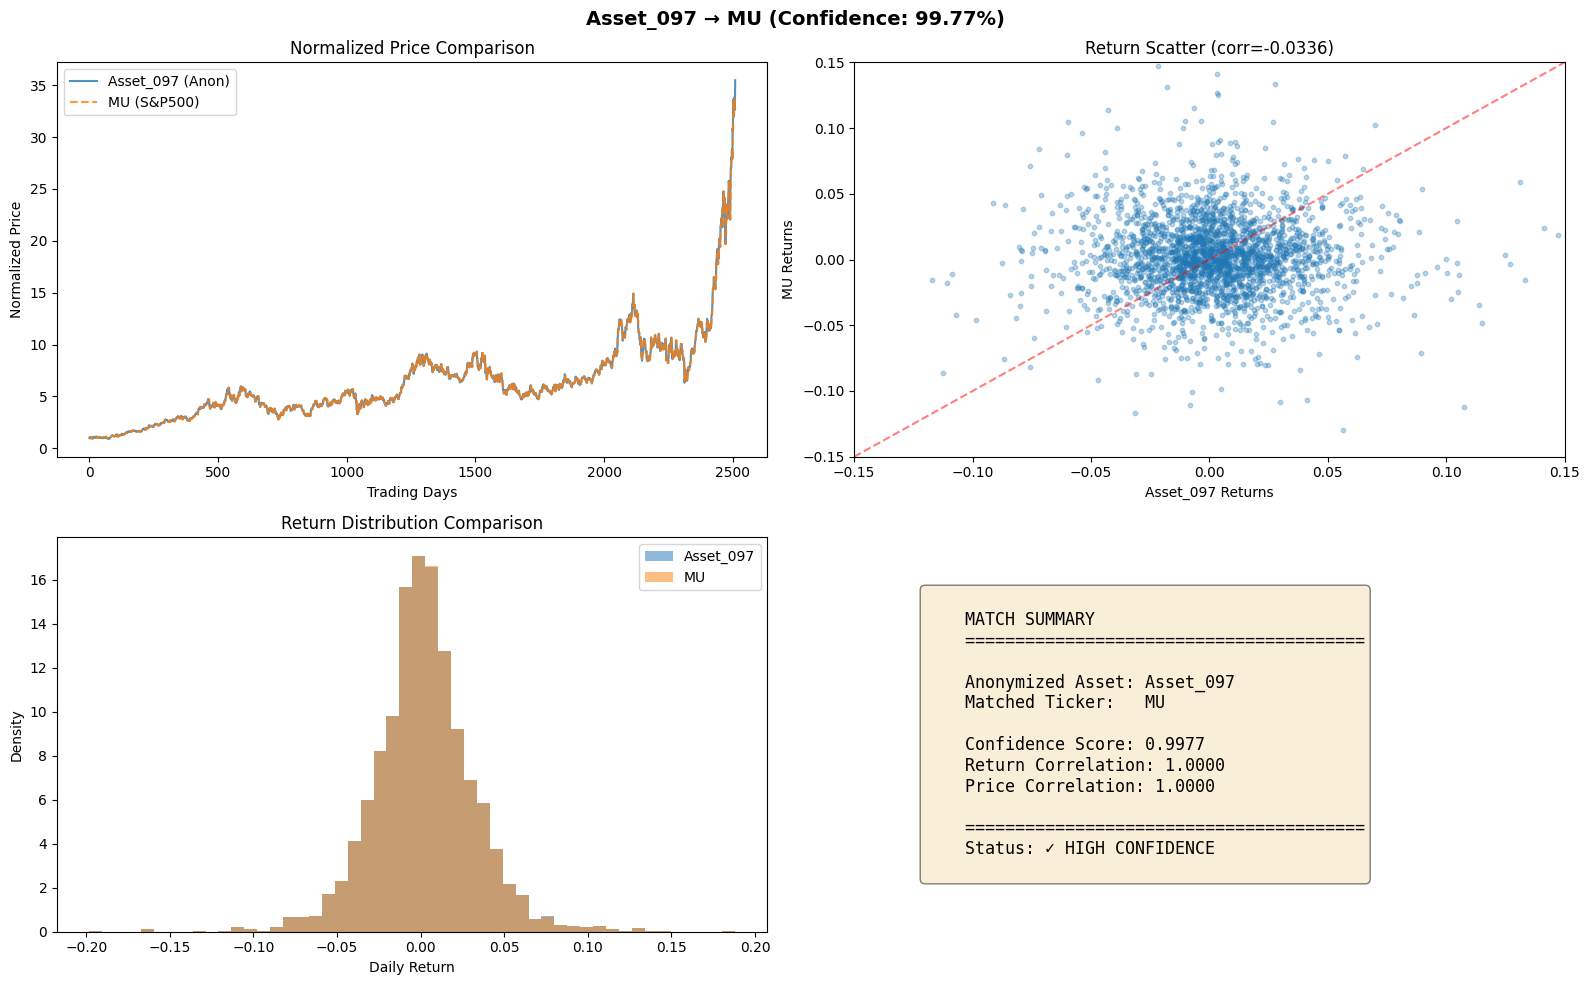

Plotting Asset_030 vs MCD...


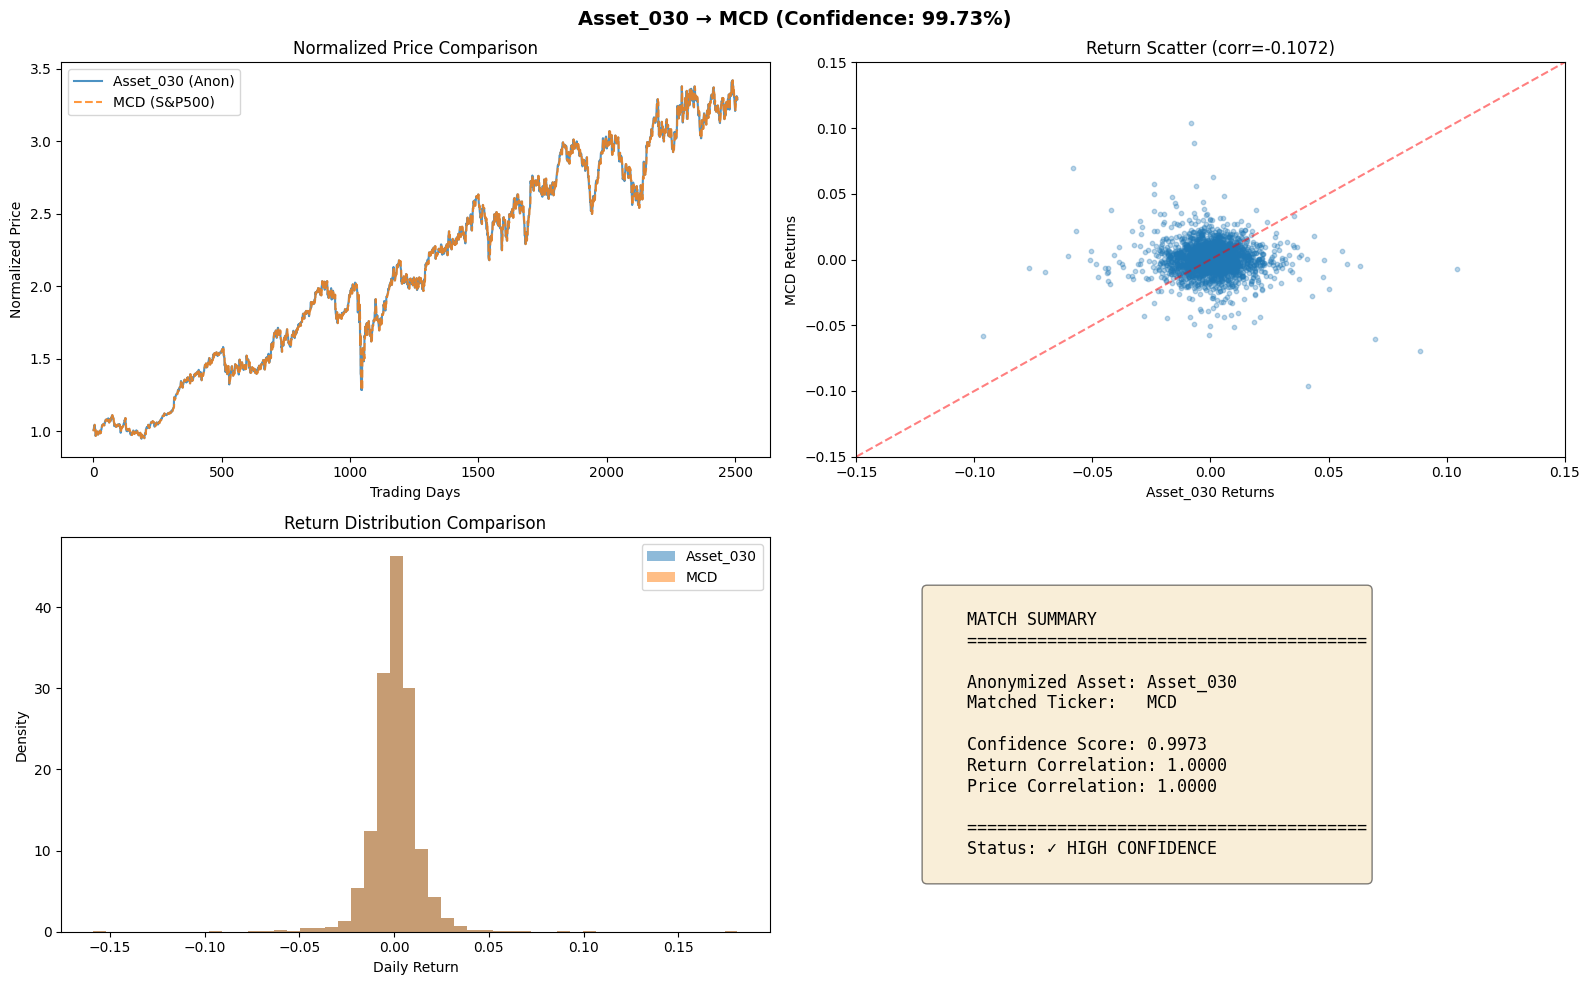

Plotting Asset_003 vs GOOG...


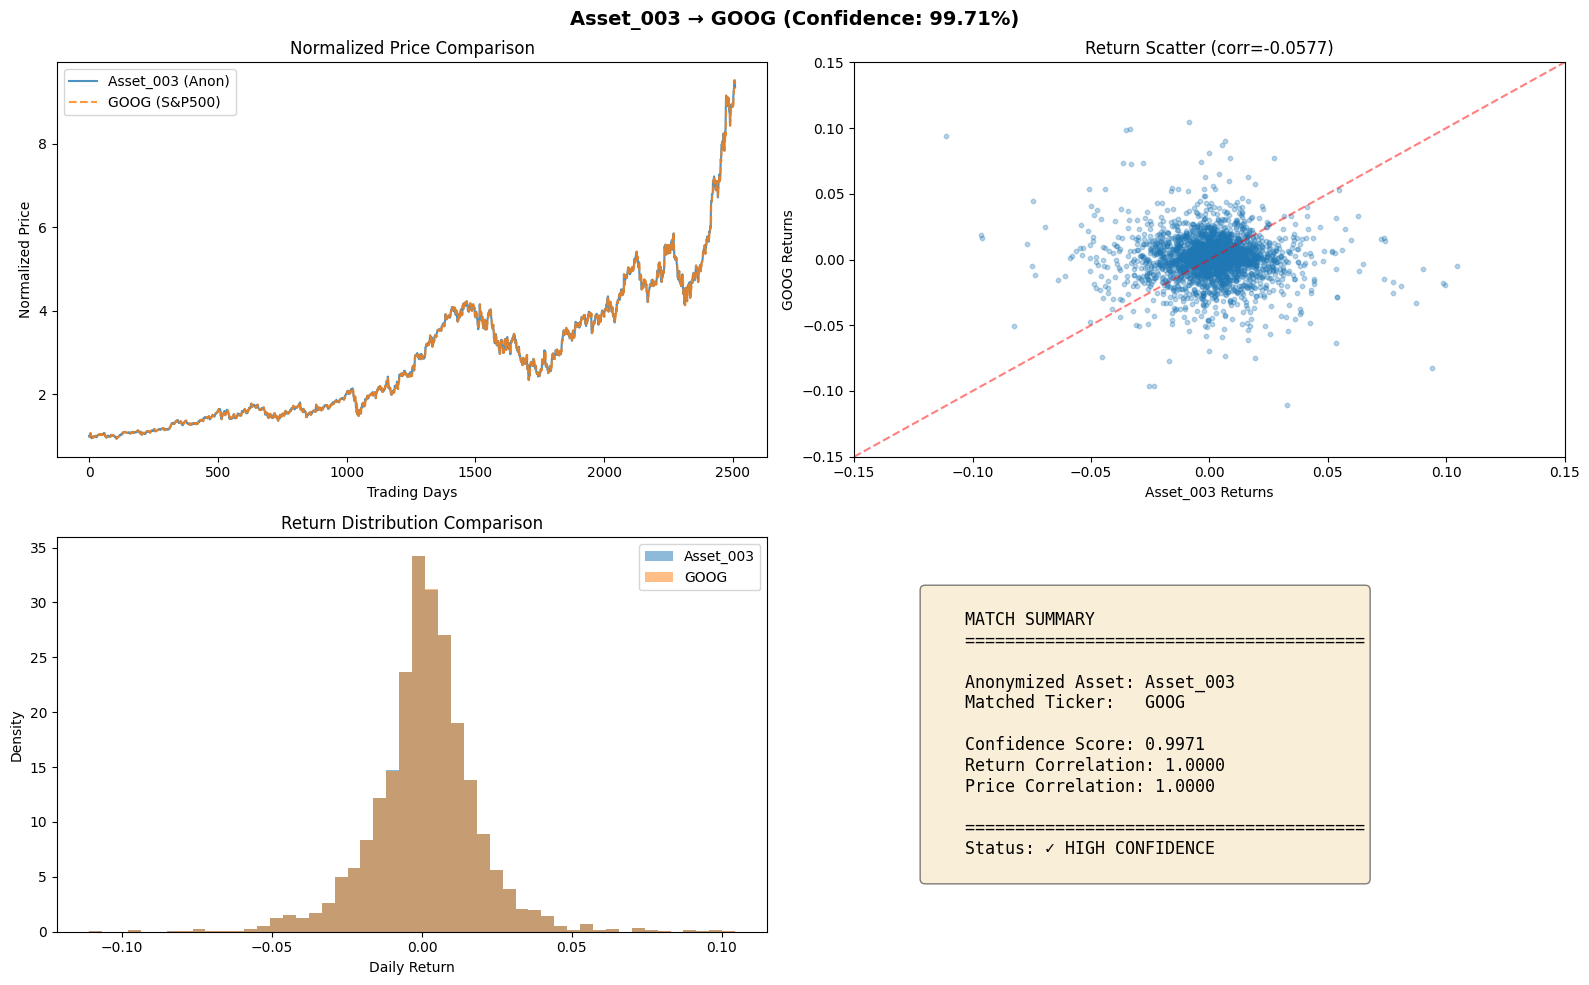

Plotting Asset_086 vs CB...


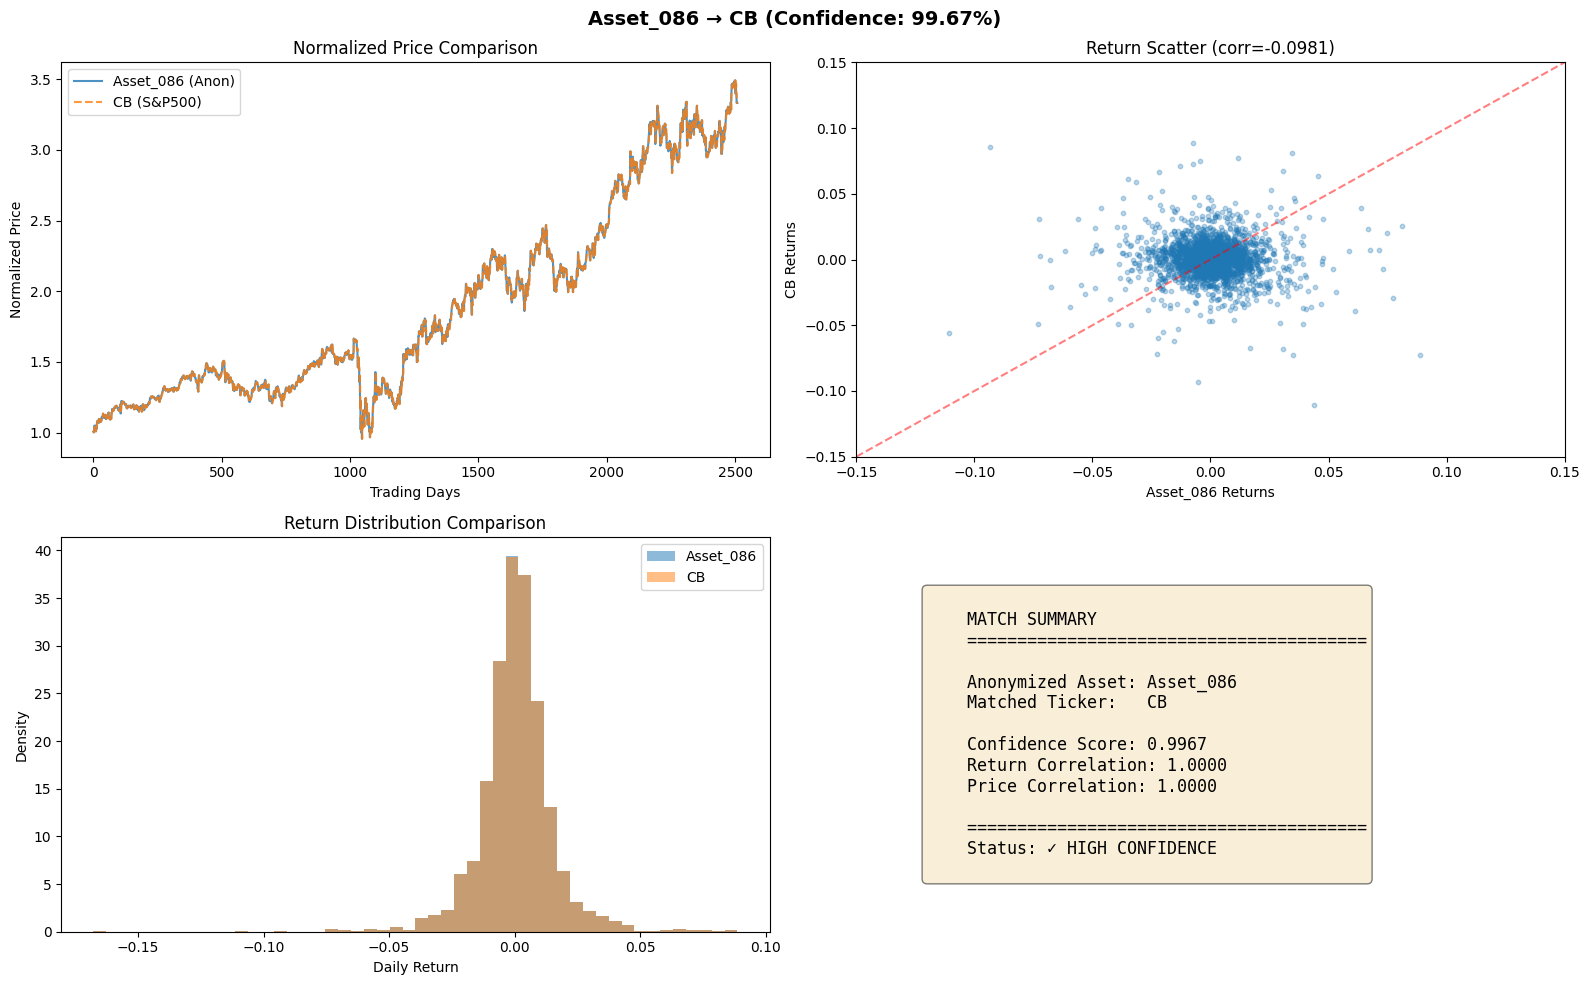

Plotting Asset_084 vs MO...


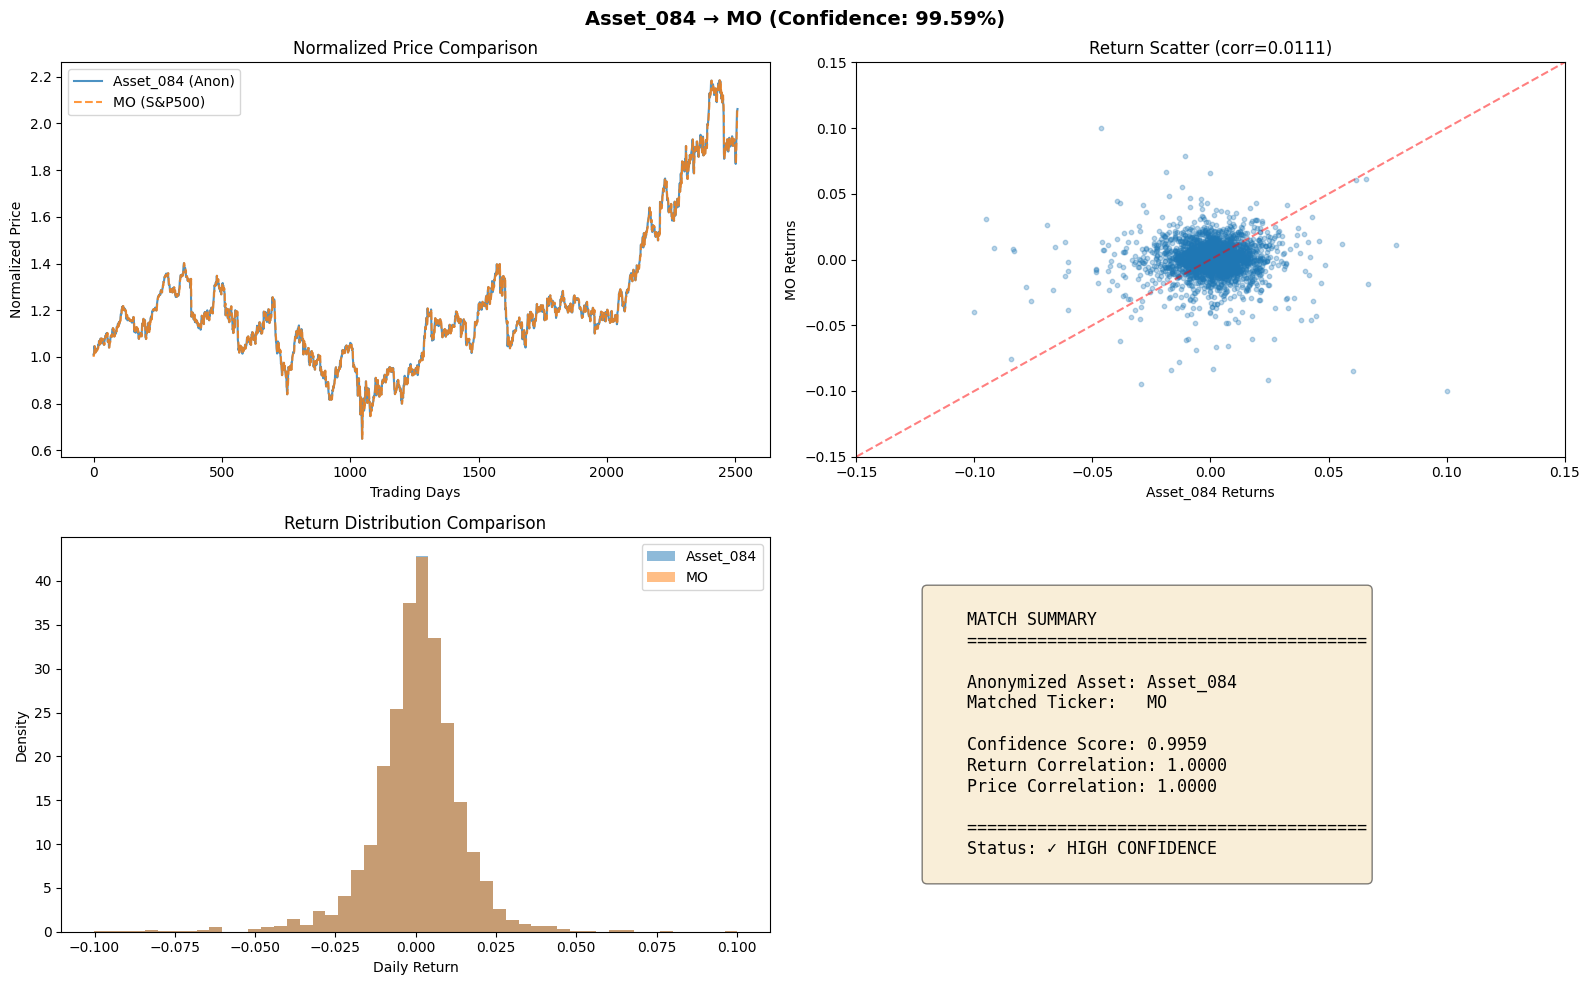

Plotting Asset_074 vs ADI...


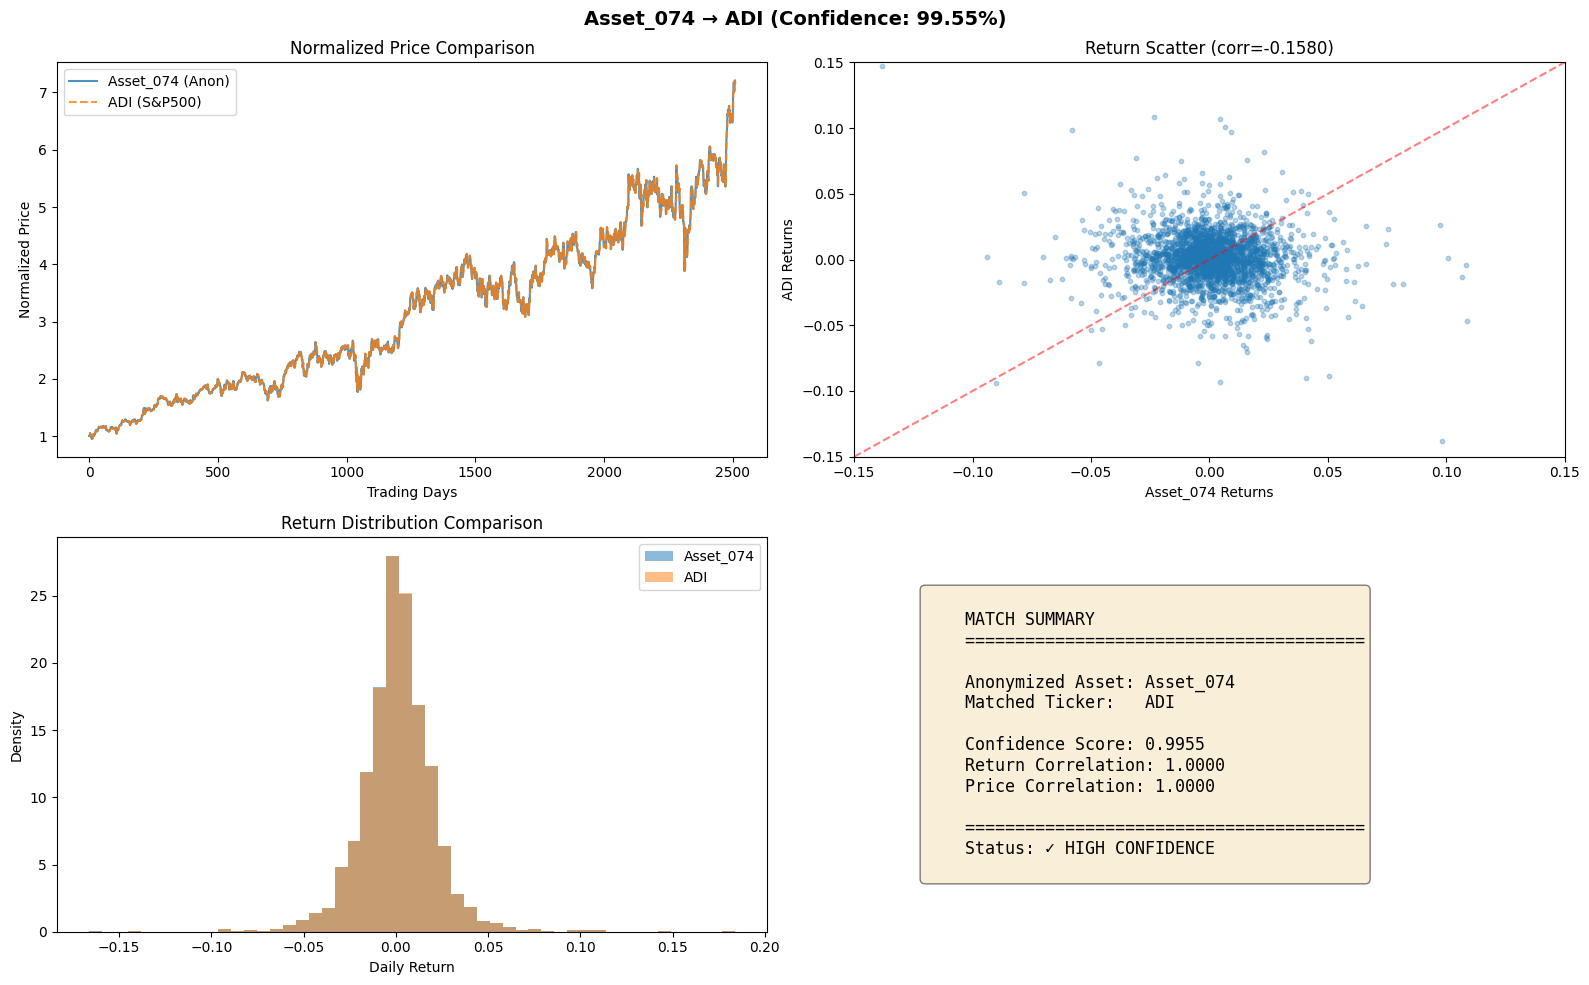

Plotting Asset_080 vs VRTX...


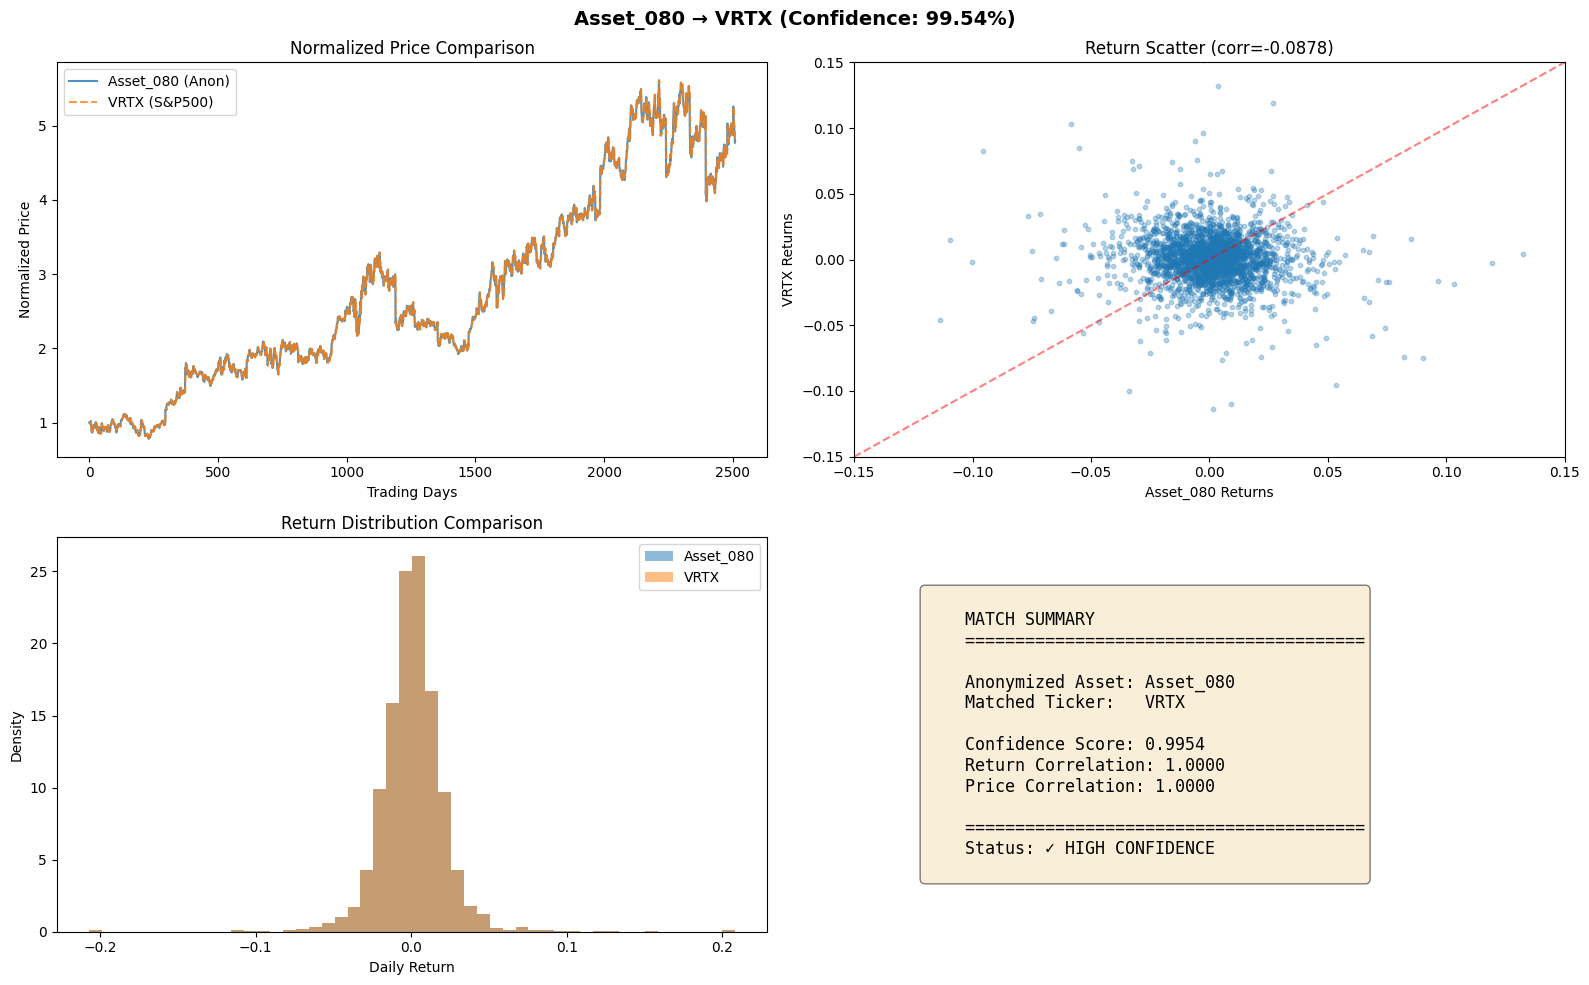

Plotting Asset_055 vs UPS...


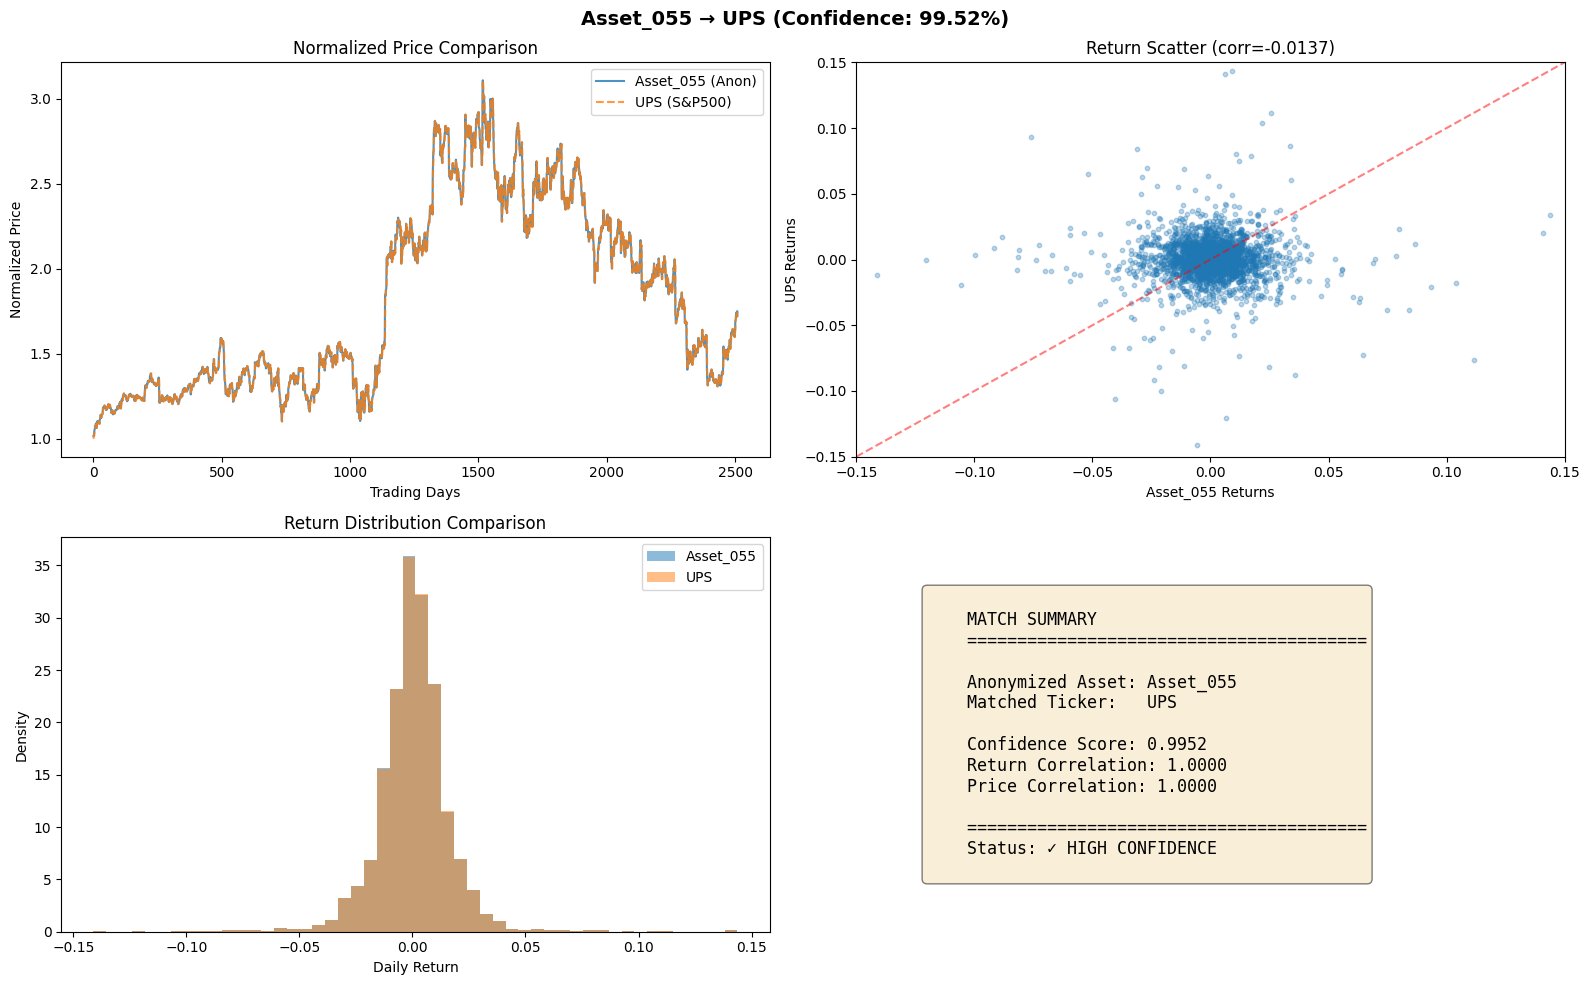

Plotting Asset_088 vs PGR...


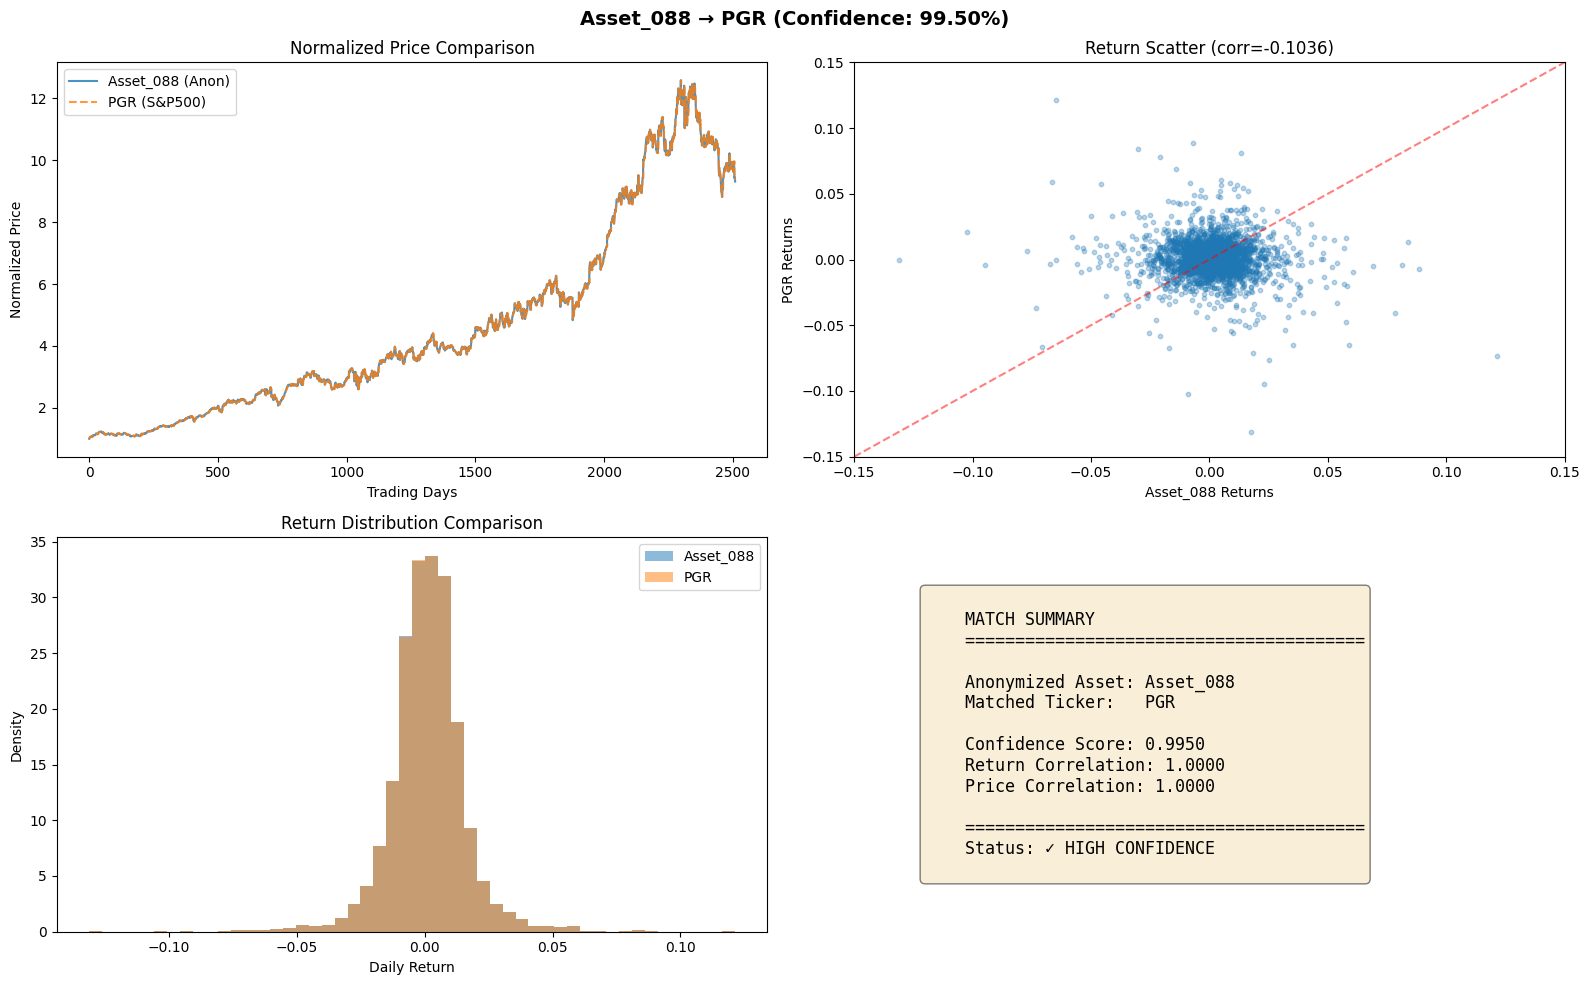

In [66]:
# =============================================================================
# VALIDATE TOP 10 MATCHES (FIXED)
# =============================================================================

print("\nVisual validation of top 10 matches:")

# Get top 10 high-confidence matches
top_matches = results_df_v2.head(10)

for _, row in top_matches.iterrows():
    # Ensure asset_id is the correct type (str) for dictionary lookup
    asset_id = str(row['asset_id']) 
    ticker = row['matched_ticker']
    
    # Check if we have data for both the asset and the ticker
    if (asset_id in anon_fingerprints) and (ticker in sp500_fingerprints):
        
        print(f"Plotting {asset_id} vs {ticker}...")
        
        fig = plot_match_comparison_v2(
            asset_id,
            anon_fingerprints[asset_id],
            sp500_fingerprints[ticker],
            row  # <--- Pass the current row directly
        )
        
        plt.savefig(OUTPUT_RESULTS / f'match_validation_{asset_id}.png', dpi=100, bbox_inches='tight')
        plt.show()
    else:
        print(f"Skipping {asset_id}: Data missing in fingerprints dictionary.")

## 6. Export Mapping

In [77]:
# =============================================================================
# EXPORT FINAL MAPPING
# =============================================================================

# Create final mapping dictionary
asset_ticker_mapping = {}
for asset_id, match in matches.items():
    asset_ticker_mapping[asset_id] = {
        'ticker': match['ticker'],
        'confidence': match['confidence']
    }

# Save as JSON
mapping_json_path = OUTPUT_RESULTS / 'asset_ticker_mapping.json'
with open(mapping_json_path, 'w') as f:
    json.dump(asset_ticker_mapping, f, indent=2)
print(f"✓ Saved mapping to: {mapping_json_path}")

# Save as CSV
mapping_csv_path = OUTPUT_RESULTS / 'asset_ticker_mapping.csv'
results_df_v2.to_csv(mapping_csv_path, index=False)
print(f"✓ Saved detailed results to: {mapping_csv_path}")

# Display simple mapping
print("\n" + "=" * 60)
print("FINAL ASSET-TICKER MAPPING")
print("=" * 60)

simple_mapping = results_df_v2[['asset_id', 'matched_ticker', 'confidence']].copy()
simple_mapping = simple_mapping.sort_values('asset_id')
display(simple_mapping)

✓ Saved mapping to: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\results\asset_ticker_mapping.json
✓ Saved detailed results to: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\results\asset_ticker_mapping.csv

FINAL ASSET-TICKER MAPPING


,asset_id,matched_ticker,confidence
62,Asset_001,AAPL,0.972526
79,Asset_002,MSFT,0.961357
3,Asset_003,GOOG,0.997139
27,Asset_004,AMZN,0.985585
67,Asset_005,NVDA,0.969041
...,...,...,...
22,Asset_096,ITW,0.988143
1,Asset_097,MU,0.997716
51,Asset_098,CL,0.976779
48,Asset_099,EQIX,0.977094


In [69]:
[['asset_id', 'matched_ticker', 'confidence']].copy()
simple_mapping = simple_mapping.sort_values('asset_id')
display(simple_mapping)

,asset_id,matched_ticker,confidence
62,Asset_001,AAPL,0.972526
79,Asset_002,MSFT,0.961357
3,Asset_003,GOOG,0.997139
27,Asset_004,AMZN,0.985585
67,Asset_005,NVDA,0.969041
...,...,...,...
22,Asset_096,ITW,0.988143
1,Asset_097,MU,0.997716
51,Asset_098,CL,0.976779
48,Asset_099,EQIX,0.977094


In [74]:
# =============================================================================
# SUMMARY STATISTICS
# =============================================================================

print("\n" + "=" * 60)
print("MATCHING SUMMARY")
print("=" * 60)

# Unique tickers matched
unique_tickers = results_df_v2['matched_ticker'].nunique()
print(f"\nUnique tickers matched: {unique_tickers}")

# Most common matched tickers (potential duplicates)
ticker_counts = results_df_v2['matched_ticker'].value_counts()
duplicates = ticker_counts[ticker_counts > 1]

if len(duplicates) > 0:
    print(f"\n⚠ Warning: {len(duplicates)} tickers matched to multiple assets:")
    print(duplicates)
    print("\nThese may need manual verification.")
else:
    print("\n✓ All matches are unique (no duplicate tickers)")

# Confidence breakdown
print(f"\nConfidence Breakdown:")
print(f"  Very High (>0.99): {(results_df_v2['confidence'] > 0.99).sum()}")
print(f"  High (0.95-0.99): {((results_df_v2['confidence'] >= 0.95) & (results_df['confidence'] <= 0.99)).sum()}")
print(f"  Medium (0.8-0.95): {((results_df_v2['confidence'] >= 0.8) & (results_df['confidence'] < 0.95)).sum()}")
print(f"  Low (<0.8): {(results_df_v2['confidence'] < 0.8).sum()}")


MATCHING SUMMARY

Unique tickers matched: 100

✓ All matches are unique (no duplicate tickers)

Confidence Breakdown:
  Very High (>0.99): 18
  High (0.95-0.99): 99
  Medium (0.8-0.95): 99
  Low (<0.8): 1


## 7. Usage in Main Pipeline

You can now use the mapping in your main notebooks:

In [75]:
# =============================================================================
# EXAMPLE: HOW TO USE THE MAPPING
# =============================================================================

# Load the mapping
def load_asset_mapping(filepath: Path) -> Dict:
    """Load asset-ticker mapping from JSON."""
    with open(filepath, 'r') as f:
        return json.load(f)

# Example usage
print("Example usage in main pipeline:")
print("-" * 40)
print("""
# In your notebook:
import json

# Load mapping
with open('outputs/results/asset_ticker_mapping.json', 'r') as f:
    mapping = json.load(f)

# Get ticker for an asset
ticker = mapping['Asset_001']['ticker']
confidence = mapping['Asset_001']['confidence']

# Add ticker column to your DataFrame
df['ticker'] = df['asset_id'].map(lambda x: mapping[x]['ticker'])
""")

Example usage in main pipeline:
----------------------------------------

# In your notebook:
import json

# Load mapping
with open('outputs/results/asset_ticker_mapping.json', 'r') as f:
    mapping = json.load(f)

# Get ticker for an asset
ticker = mapping['Asset_001']['ticker']
confidence = mapping['Asset_001']['confidence']

# Add ticker column to your DataFrame
df['ticker'] = df['asset_id'].map(lambda x: mapping[x]['ticker'])



In [76]:
print("\n" + "=" * 60)
print("REVERSE ENGINEERING COMPLETE!")
print("=" * 60)
print(f"\nOutputs saved to: {OUTPUT_RESULTS}")
print("  - asset_ticker_mapping.json")
print("  - asset_ticker_mapping.csv")
print("  - matching_confidence.png")
print("  - match_validation_*.png (top 10 matches)")


REVERSE ENGINEERING COMPLETE!

Outputs saved to: c:\Users\ponna\OneDrive\Desktop\Precog Task\outputs\results
  - asset_ticker_mapping.json
  - asset_ticker_mapping.csv
  - matching_confidence.png
  - match_validation_*.png (top 10 matches)
